# Tobigs Week4 Ensemble assignment

[캐글 컴페티션](https://www.kaggle.com/c/tobigs1415-kaggle-ensemble-competition/data?select=ggstore_test.csv)

# 데이터 로드 및 패키지 임포트

colab환경에서 작업했기 때문에 google drive에서 파일을 불러왔습니다.

In [ ]:
!unzip /content/drive/MyDrive/Datasets/tobigs1415-kaggle-ensemble-competition.zip -d /content/assignment_data

Archive:  /content/drive/MyDrive/Datasets/tobigs1415-kaggle-ensemble-competition.zip
  inflating: /content/assignment_data/ggstore_test.csv  
  inflating: /content/assignment_data/ggstore_train.csv  


In [ ]:
! pip install xgboost
! pip install vecstack
! pip install lightgbm

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19880 sha256=633b5d8616599a0964abec54b75d2e1e0433c670bee0fbd93a96292ee43e7b89
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [ ]:
# 패키지 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 데이터 로드
all_train_data = pd.read_csv("/content/assignment_data/ggstore_train.csv")
all_test_data = pd.read_csv("/content/assignment_data/ggstore_test.csv")

In [ ]:
all_train_data.head() # 데이터 확인

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2018-01-07,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2018-08-01,2
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,Art & Design,2018-06-08,3
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,Art & Design;Creativity,2018-06-20,4


In [ ]:
print(f"전체 학습 데이터 수 : {len(all_train_data)}")
print(f"전체 평가 데이터 수 : {len(all_test_data)}")
print(f"학습 데이터의 Columns 수 : {all_train_data.shape[1]}")
print(f"평가 데이터의 Columns 수 : {all_test_data.shape[1]}")

전체 학습 데이터 수 : 5616
전체 평가 데이터 수 : 1404
학습 데이터의 Columns 수 : 12
평가 데이터의 Columns 수 : 11


- 학습 데이터의 총 수는 5616개이며, 평가 데이터의 수는 1404로, 학습 데이터 : 평가 데이터 = 4 : 1 인 것을 확인할 수 있었다.
- 평가 데이터의 Column이 학습 데이터보다 한 개 적은 것을 확인했다. 확인이 필요할 것 같다.


# 데이터 EDA 및 전처리

## 데이터 형태 확인

앞서 확인했을때 test_data의 columns수가 한 개 적은것을 확인해서 체크해 보았다.

In [ ]:
all_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5616 entries, 0 to 5615
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             5616 non-null   object 
 1   Category        5616 non-null   object 
 2   Rating          5616 non-null   float64
 3   Reviews         5616 non-null   int64  
 4   Size            5616 non-null   float64
 5   Installs        5616 non-null   float64
 6   Type            5616 non-null   int64  
 7   Price           5616 non-null   float64
 8   Content Rating  5616 non-null   object 
 9   Genres          5616 non-null   object 
 10  Last Updated    5616 non-null   object 
 11  Id              5616 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 526.6+ KB


In [ ]:
all_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             1404 non-null   object 
 1   Category        1404 non-null   object 
 2   Reviews         1404 non-null   int64  
 3   Size            1404 non-null   float64
 4   Installs        1404 non-null   float64
 5   Type            1404 non-null   int64  
 6   Price           1404 non-null   float64
 7   Content Rating  1404 non-null   object 
 8   Genres          1404 non-null   object 
 9   Last Updated    1404 non-null   object 
 10  Id              1404 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 120.8+ KB


확인 결과 예측해야하는 변수인 Rating 이 사라진 것을 확인할 수 있다.

`all_test_data` 는 데이터 평가시 평가의 지표가 되는 데이터로 생각되며, Validation 용도로 사용하는 것이 아닐 것으로 추측된다.

따라서 `all_test_data` 는 사용하지 않겠다.

In [ ]:
all_train_data.describe()

,Rating,Reviews,Size,Installs,Type,Price,Id
count,5616.000000,5.616000e+03,5616.000000,5.616000e+03,5616.000000,5616.000000,5616.000000
mean,4.177386,1.686437e+05,21.831198,5.201445e+06,0.078526,1.409918,2807.500000
std,0.543153,1.126012e+06,22.744877,3.012485e+07,0.269021,20.341193,1621.343887
min,1.000000,1.000000e+00,0.008500,1.000000e+00,0.000000,0.000000,0.000000
25%,4.000000,1.140000e+02,5.100000,1.000000e+04,0.000000,0.000000,1403.750000
50%,4.300000,2.158000e+03,13.000000,1.000000e+05,0.000000,0.000000,2807.500000
75%,4.500000,3.292125e+04,30.000000,1.000000e+06,0.000000,0.000000,4211.250000
max,5.000000,4.489172e+07,100.000000,1.000000e+09,1.000000,400.000000,5615.000000


`describe()` 를 사용해 본 결과 특별한 이상은 보이지 않았다.

In [ ]:
for col in all_train_data.columns:
  print(f"{col}의 Unique 개수 : {len(all_train_data[col].unique())} \n\n ")

App의 Unique 개수 : 5616 

 
Category의 Unique 개수 : 33 

 
Rating의 Unique 개수 : 38 

 
Reviews의 Unique 개수 : 3697 

 
Size의 Unique 개수 : 352 

 
Installs의 Unique 개수 : 19 

 
Type의 Unique 개수 : 2 

 
Price의 Unique 개수 : 61 

 
Content Rating의 Unique 개수 : 6 

 
Genres의 Unique 개수 : 106 

 
Last Updated의 Unique 개수 : 1132 

 
Id의 Unique 개수 : 5616 

 


전체 Column 별로 Unique value의 수를 확인해 보았다.

범주형 변수가 아닌, 수치형 변수의 개수는 전체 데이터 개수인 5616개에 흡사하게 나올 것으로 예상되었다.

눈에 띄는 점을 정리하면 다음과 같았다.
- `Installs` 가 19개밖에 되지 않았다. 다운 수를 큰 수에서 반올림하기 때문일 것으로 생각된다. 이는 연속형 변수보다는 범주형에 가까운 수치라고 생각된다.
- `Price`가 61개정도로 개수가 낮게 나왔다.
- `Genre`의 개수는 상당히 많이 나왔다. 또한 `Category` 변수와의 상관관계가 의심된다.
- `Last Updated` 의 날짜 분포를 알아야 알 듯 하다.
- `Id` 변수는 단순히 id값으로, 차후 제거가 필요하다.

위에서 나온 변수들을 위주로 value값도 확인해 보았다.

In [ ]:
chk_cols = ['Installs','Price', 'Type', 'Content Rating', 'Category', 'Genres', 'Last Updated']
for col in chk_cols:
  print(f"{col}의 Unique 개수 : {len(all_train_data[col].unique())} \n values : {all_train_data[col].unique()} \n\n ")

Installs의 Unique 개수 : 19 
 values : [1.e+04 5.e+05 5.e+06 5.e+07 1.e+05 5.e+04 1.e+06 1.e+07 5.e+03 1.e+08
 1.e+03 5.e+08 1.e+02 5.e+02 1.e+01 1.e+09 5.e+00 5.e+01 1.e+00] 

 
Price의 Unique 개수 : 61 
 values : [  0.     4.99   6.99   7.99   3.99   5.99   2.99   1.99   9.99   0.99
   9.     5.49  10.    24.99  11.99  79.99  16.99  14.99  29.99  12.99
   3.49  10.99   7.49   1.5   19.99  15.99  33.99  39.99   2.49   4.49
   1.7    1.49   3.88 399.99  17.99 400.     3.02   1.76   4.84   4.77
   1.61   1.59   6.49   1.29 299.99 379.99  37.99  18.99 389.99   8.49
   1.75  14.     2.     3.08   2.59  19.4   15.46   8.99   3.04  13.99
   4.29] 

 
Type의 Unique 개수 : 2 
 values : [0 1] 

 
Content Rating의 Unique 개수 : 6 
 values : ['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated'] 

 
Category의 Unique 개수 : 33 
 values : ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' '

확인 결과는 다음과 같았다.
- `Installs` 는 1부터 1.e+09 까지 반올림시켜놓은 범주형 변수로 생각돼야 할 것 같다.
- `Price` 는 각 앱별로 가격이 비슷하기 때문으로 범주형 변수로 취급하기는 어려울 것 같다.
- `Type` 는 0과 1 두 개의 값으로 이루어저 있다.
- `Content Rating` 은 앱의 연령제한인 범주형 변수이다.
- `Genre`는 `Category` 의 하위 분류까지 나눠져 있다. 하지만 데이터의 개수를 생각해 보았을 때 오버피팅의 염려가 있을 수도 있어 보인다.
- `Last Updated`는 단순히 날짜이다. 개수가 1132개로 나누어져 있는 것으로 볼 때 상당히 많은 수의 날짜를 포함하며, 이를 범주형으로 나누면 과적합 우려가 있기 때문에 연속형 변수로 바꿀 방법을 생각해야겠다.

또한 데이터 내부에 결측치는 존재하지 않았다.

## 히스토그램
데이터 각각의 막대그래프, 히스토그램을 그려 보았다.

### Category


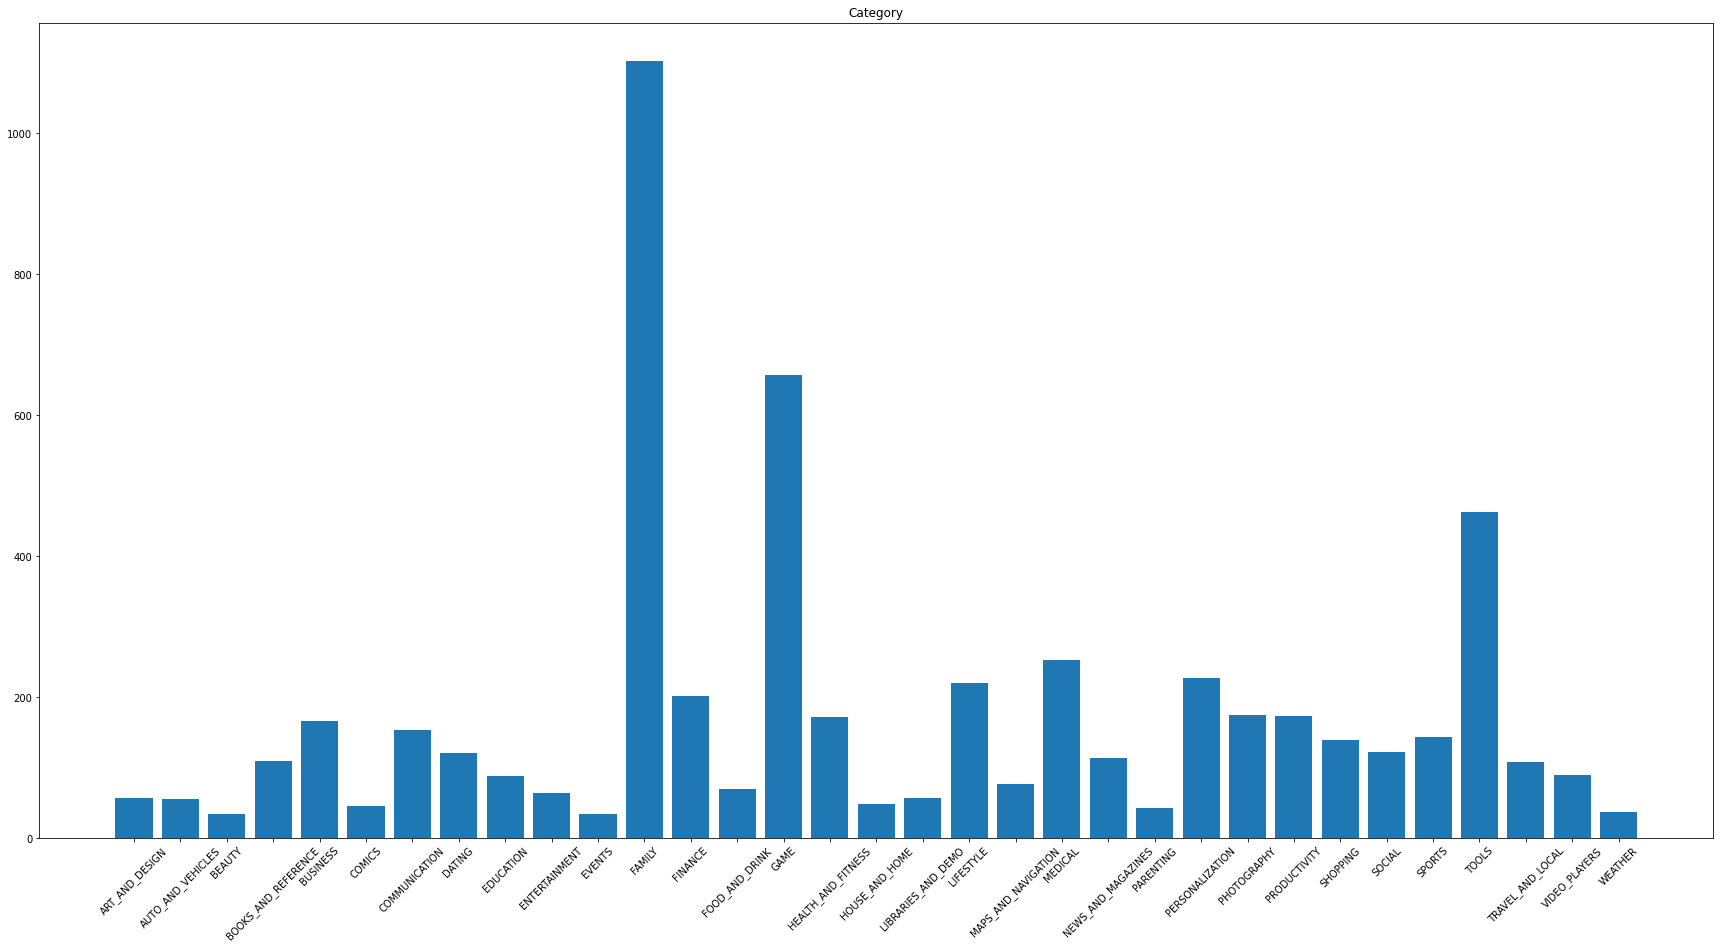

In [ ]:
grouped_data = all_train_data.groupby(['Category'], as_index=False).count()
plt.figure(figsize = (30,15))
plt.bar(grouped_data['Category'].values, grouped_data['Id'])
plt.title("Category")
plt.xticks(rotation=45) 
plt.show()

- Family, Game, Tools 가 다른 앱에 비해 상당히 많은 것을 볼 수 있었다. 주의가 필요할 것 같다.

### Rating

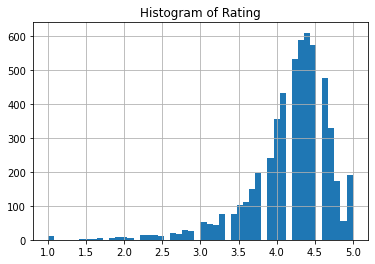

In [ ]:
all_train_data["Rating"].hist(bins=50) # 0.0부터 5.0까지
plt.title("Histogram of Rating")
plt.show()

- 로그 변환을 수행해 줄 필요가 있어 보인다.

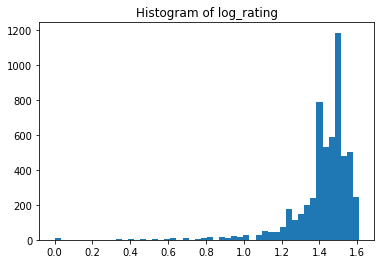

In [ ]:
log_rating_data = np.log(all_train_data["Rating"])
plt.hist(log_rating_data, bins=50)
plt.title("Histogram of log_rating")
plt.show()

로그 변환을 수행해도 정규성에 큰 변화가 없어 보이며, 오히려 정규성이 더 줄어든 것 처럼 보인다.

`Rating` 은 예측변수로서, 크게 편향된 값이 없다고 생각할 수 있을 것 같다.

### Reviews

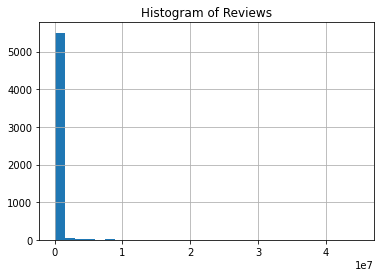

In [ ]:
all_train_data["Reviews"].hist(bins=30)
plt.title("Histogram of Reviews")
plt.show()

데이터의 편차가 커서 잘 관측되지 않아 보인다.
따라서 로그변환을 수행 후 확인해 보겠다.

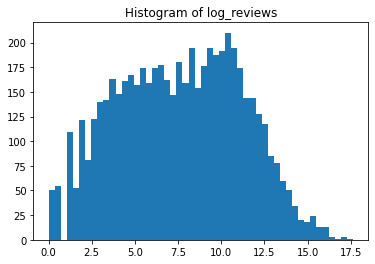

In [ ]:
log_reviews_data = np.log(all_train_data["Reviews"])
plt.hist(log_reviews_data, bins=50)
plt.title("Histogram of log_reviews")
plt.show()

데이터가 잘 분포된 것을 확인할 수 있었다.

`Reviews` 피처의 최소값이 1이었기때문에 따로 편향을 더하지 않았다.

### Size

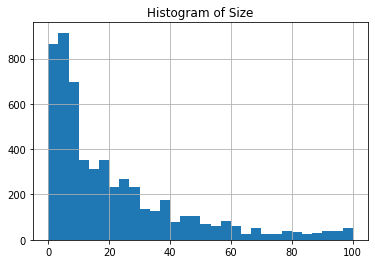

In [ ]:
all_train_data["Size"].hist(bins=30)
plt.title("Histogram of Size")
plt.show()

데이터가 좌편향되어있기 때문에 로그 변환을 진행하고 다시 확인했다.

하지만 최소값이 0에 근접한 값이 있었기 때문에 1을 더해 로그 변향을 수행했다.

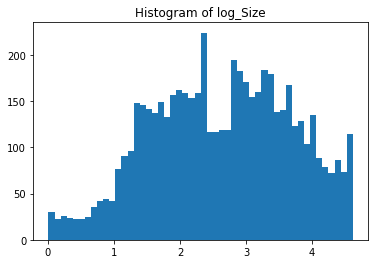

In [ ]:
log_Size_data = np.log(all_train_data["Size"] + 1)
plt.hist(log_Size_data, bins=50)
plt.title("Histogram of log_Size")
plt.show()

큰 이상 없이 잘 분포한 것을 확인할 수 있었다.

### Installs
앞서 분석했듯 범주형 변수로 간주하고 표시해 보겠다.

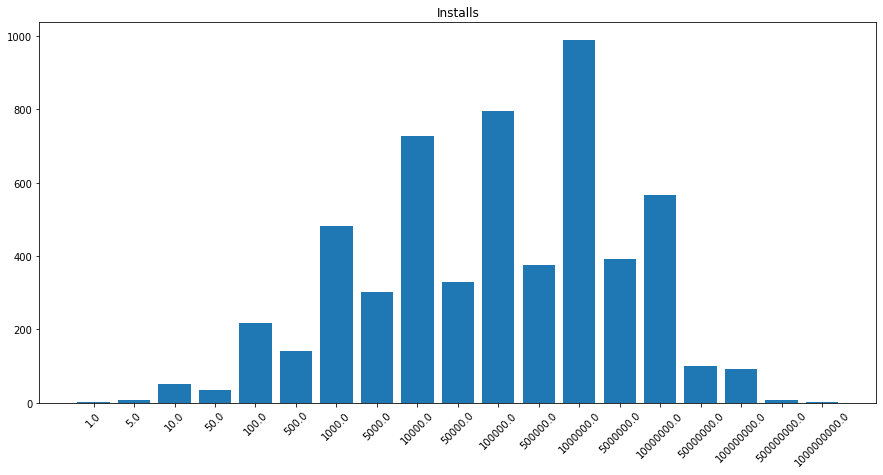

In [ ]:
grouped_data = all_train_data.groupby(['Installs'], as_index=False).count()
plt.figure(figsize = (15,7))
plt.bar(grouped_data['Installs'].astype(str), grouped_data['Id']) # astype을 통해 string 변환
plt.title("Installs")
plt.xticks(rotation=45) 
plt.show()

큰 문제 없이 정규분포와 비슷한 모양을 갖는다. (연속형 변수였기 때문에)

단지 앞자리가 5인 범주에서는 데이터가 조금씩 적은 모습을 보이는데 조금 더 확인해야할 부분으로 보인다. (반올림을 하는 방법의 차이로 추측이 된다.)

따라서 범주를 조금 더 크게 묶어서 10의 제곱단위로만 계산해 보기로 했다.



In [ ]:
bins = [1*(10**i) for i in range(0,10)] # 1부터 1e9까지 구간 생성
bin_label = [str(label) + '+' for label in bins] # 구간에 + 을 붙여 레이블 생성
cut_installs = pd.cut(all_train_data["Installs"], bins = bins, right=True, labels=bin_label[:-1]) # 10의 지수배 구간으로 cutting

In [ ]:
cut_installs # 잘 나눠졌다?

0           1000+
1         100000+
2        1000000+
3       10000000+
4          10000+
          ...    
5611      100000+
5612      100000+
5613        1000+
5614       10000+
5615          10+
Name: Installs, Length: 5616, dtype: category
Categories (9, object): ['1+' < '10+' < '100+' < '1000+' ... '100000+' < '1000000+' < '10000000+' <
                         '100000000+']

#### (기록) 오류수정
위 방법으로 진행했는데 NaN값이 확인되어 수정을 진행했다.

`pd.cut()` 함수는 왼쪽 경계값을 포함하지 않기 때문에 다운로드 수가 1인 데이터는 포함되지 않았기 때문이다.

In [ ]:
cut_installs.unique() # NaN 값이 확인되어 체크

['1000+', '100000+', '1000000+', '10000000+', '10000+', '100+', '100000000+', '10+', '1+', NaN]
Categories (9, object): ['1+' < '10+' < '100+' < '1000+' ... '100000+' < '1000000+' < '10000000+' <
                         '100000000+']

In [ ]:
all_train_data[cut_installs.isnull() == True] # Null인 부분의 Index 체크

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
1436,KBA-EZ Health Guide,MEDICAL,5.0,4,25.0,1.0,0,0.00,Everyone,Medical,2018-08-02,1436
3646,Ra Ga Ba,GAME,5.0,2,20.0,1.0,1,1.49,Everyone,Arcade,2017-02-08,3646


In [ ]:
all_train_data[all_train_data['Installs'] == 1] # 1일때 NaN 값으로 변환되는 것을 확인했다.

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
1436,KBA-EZ Health Guide,MEDICAL,5.0,4,25.0,1.0,0,0.00,Everyone,Medical,2018-08-02,1436
3646,Ra Ga Ba,GAME,5.0,2,20.0,1.0,1,1.49,Everyone,Arcade,2017-02-08,3646


In [ ]:
# 개수가 얼마 되지 않고, 모두 1이었기 때문에 수작업으로 대체했다.
cut_installs[1436] = '1+'
cut_installs[3646] = '1+'

In [ ]:
cut_installs.isnull().sum() # NaN값을 제거했다.

0

In [ ]:
cut_installs.value_counts().sort_index()

1+              61
10+            254
100+           621
1000+         1030
10000+        1124
100000+       1364
1000000+       959
10000000+      193
100000000+      10
Name: Installs, dtype: int64

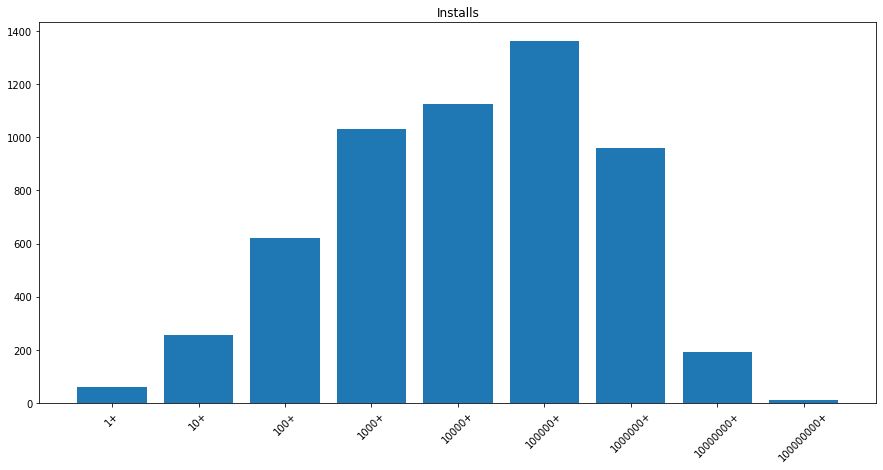

In [ ]:
plt.figure(figsize = (15,7))
plt.bar(sorted(cut_installs.unique().astype(str)), cut_installs.value_counts().sort_index()) # astype을 통해 string 변환
plt.title("Installs")
plt.xticks(rotation=45) 
plt.show()

정규성을 만족하는 것 처럼 그려진다.

수치형으로 해석해서 사용할 수도 있을 것 같다.

### Type

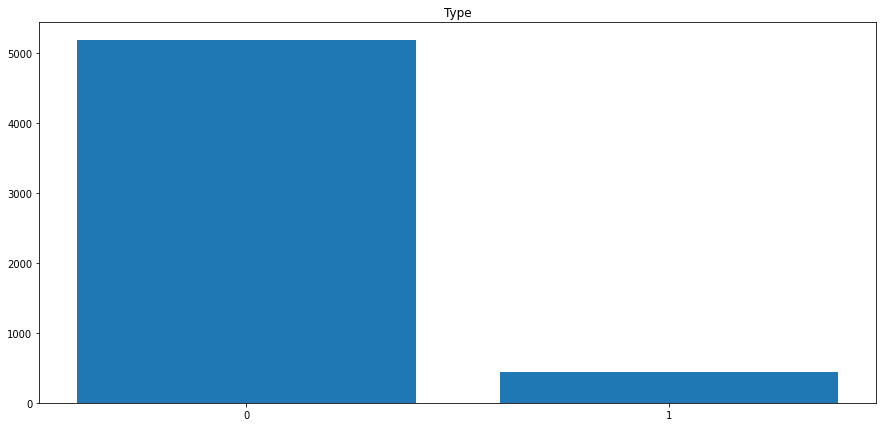

In [ ]:
grouped_data = all_train_data.groupby(['Type'], as_index=False).count()
plt.figure(figsize = (15,7))
plt.bar(['0','1'], grouped_data['Id'])
plt.title("Type")
plt.show()

`Type`이 0인 것이 1인 것에 비해 매우 많은 것으로 확인된다.


### Price

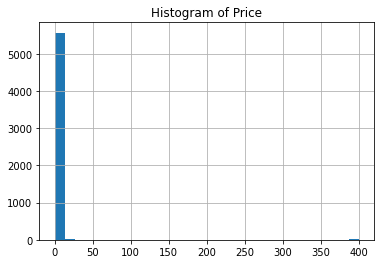

In [ ]:
all_train_data["Price"].hist(bins=30)
plt.title("Histogram of Price")
plt.show()

400불에 가까운 앱이 관측이 되었다.

데이터를 체크해 보자.

In [ ]:
all_train_data[all_train_data['Price'] > 100] # 100달러가 넘어가는 앱 확인

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
2392,most expensive app (H),FAMILY,4.3,6,1.500,100.0,1,399.99,Everyone,Entertainment,2018-07-16,2392
2506,💎 I'm rich,LIFESTYLE,3.8,718,26.000,10000.0,1,399.99,Everyone,Lifestyle,2018-03-11,2506
2510,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.300,10000.0,1,400.00,Everyone,Lifestyle,2018-05-03,2510
3232,I am rich,LIFESTYLE,3.8,3547,1.800,100000.0,1,399.99,Everyone,Lifestyle,2018-01-12,3232
3234,I am Rich Plus,FAMILY,4.0,856,8.700,10000.0,1,399.99,Everyone,Entertainment,2018-05-19,3234
3235,I am rich VIP,LIFESTYLE,3.8,411,2.600,10000.0,1,299.99,Everyone,Lifestyle,2018-07-21,3235
3236,I Am Rich Premium,FINANCE,4.1,1867,4.700,50000.0,1,399.99,Everyone,Finance,2017-11-12,3236
3237,I am extremely Rich,LIFESTYLE,2.9,41,2.900,1000.0,1,379.99,Everyone,Lifestyle,2018-07-01,3237
3238,I am Rich!,FINANCE,3.8,93,22.000,1000.0,1,399.99,Everyone,Finance,2017-12-11,3238
3239,I am rich(premium),FINANCE,3.5,472,0.965,5000.0,1,399.99,Everyone,Finance,2017-05-01,3239


데이터를 확인해 보니 모든 앱이 다 "I am Rich" 관련 앱이다.

이런 앱은 기능이 없지만 비싼 가격을 책정해 관심을 유도하고, 과시를 위해 구매하는 앱이다. 

따라서 이와 같이 비싼 가격은 정상적으로 판단되었다.

하지만 금액이 매우 커서 정상적으로 처리하기 어렵기 때문에 로그 변환을 수행했다.

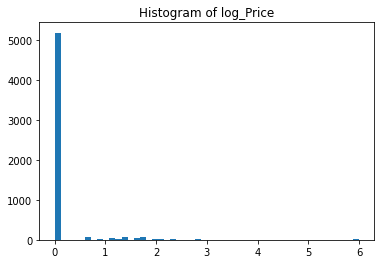

In [ ]:
log_Price_data = np.log(all_train_data["Price"] + 1) # 가격이 0인 앱이 많기 때문에 1을 더했다.
plt.hist(log_Price_data, bins=50)
plt.title("Histogram of log_Price")
plt.show()

In [ ]:
log_Price_data[log_Price_data < 1].value_counts()

0.000000    5175
0.688135      79
0.912283      22
0.993252       2
0.828552       1
0.959350       1
0.951658       1
0.916291       1
Name: Price, dtype: int64

0인 데이터가 매우 많아 그래프가 정상적으로 그려지지 않는다.

### Content Rating

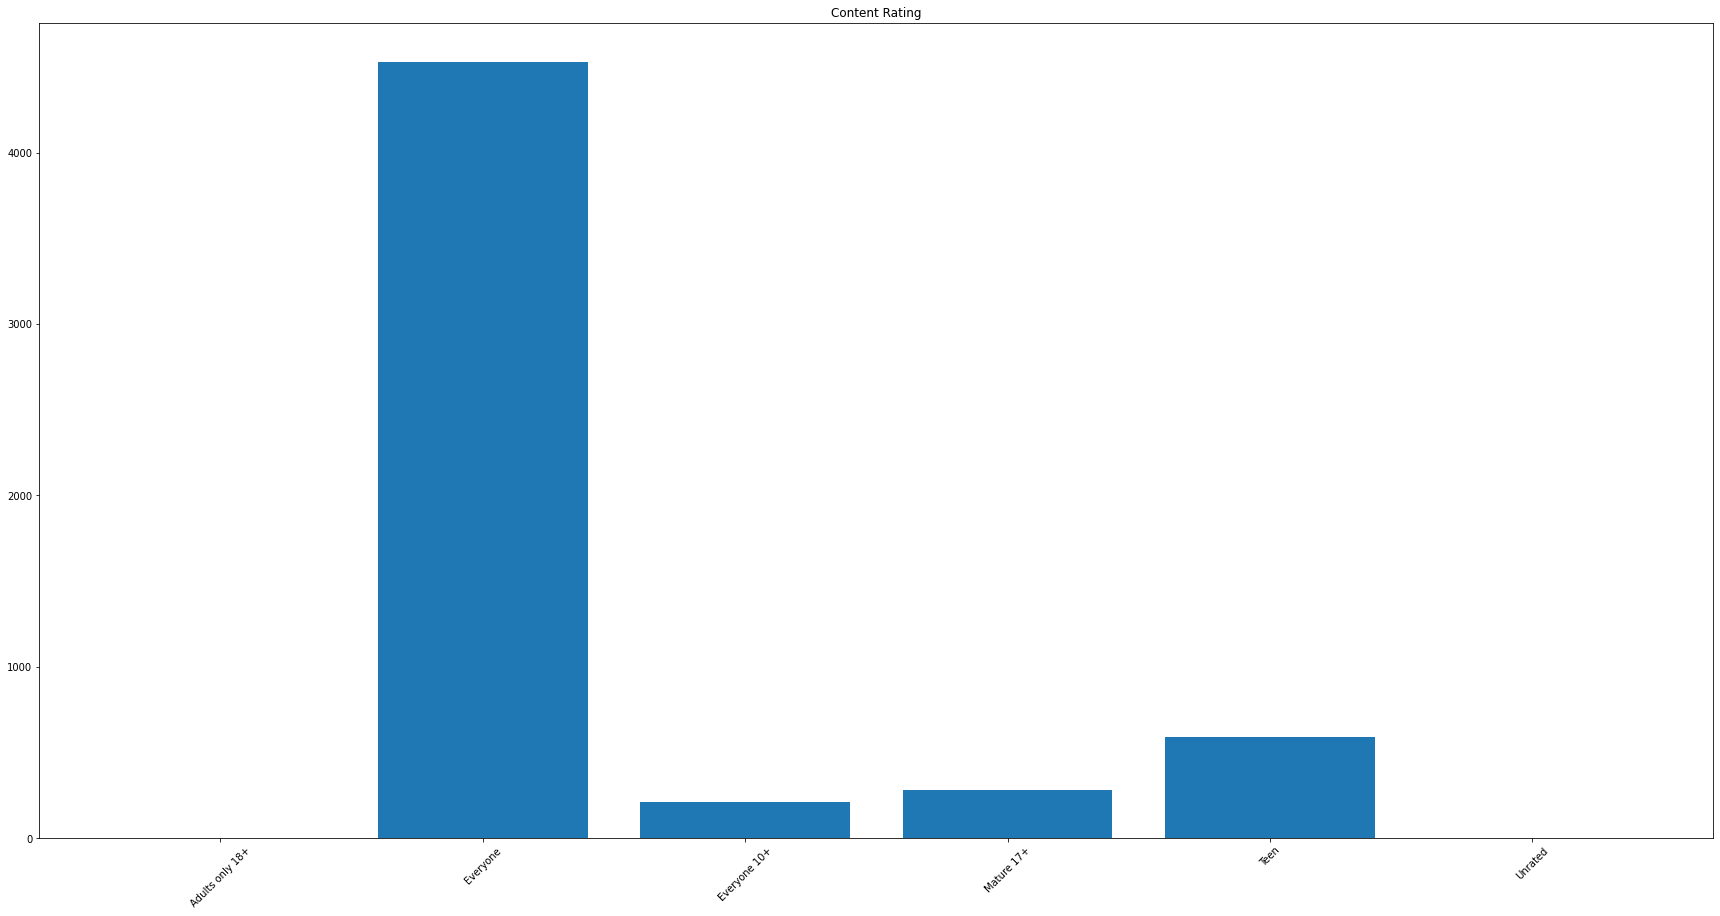

In [ ]:
grouped_data = all_train_data.groupby(['Content Rating'], as_index=False).count()
plt.figure(figsize = (30,15))
plt.bar(grouped_data['Content Rating'].values, grouped_data['Id'])
plt.title("Content Rating")
plt.xticks(rotation=45) 
plt.show()

대부분의 앱이 "Everyone" 등급이다.

"Unrated"는 결측치로 생각할 수도 있지만, 제작자가 관리를 하지 않아 등급이 없는 것으로 생각될 수 있어 평점에 유의미한 영향을 줄 것이라고 생각했다.

### Genres

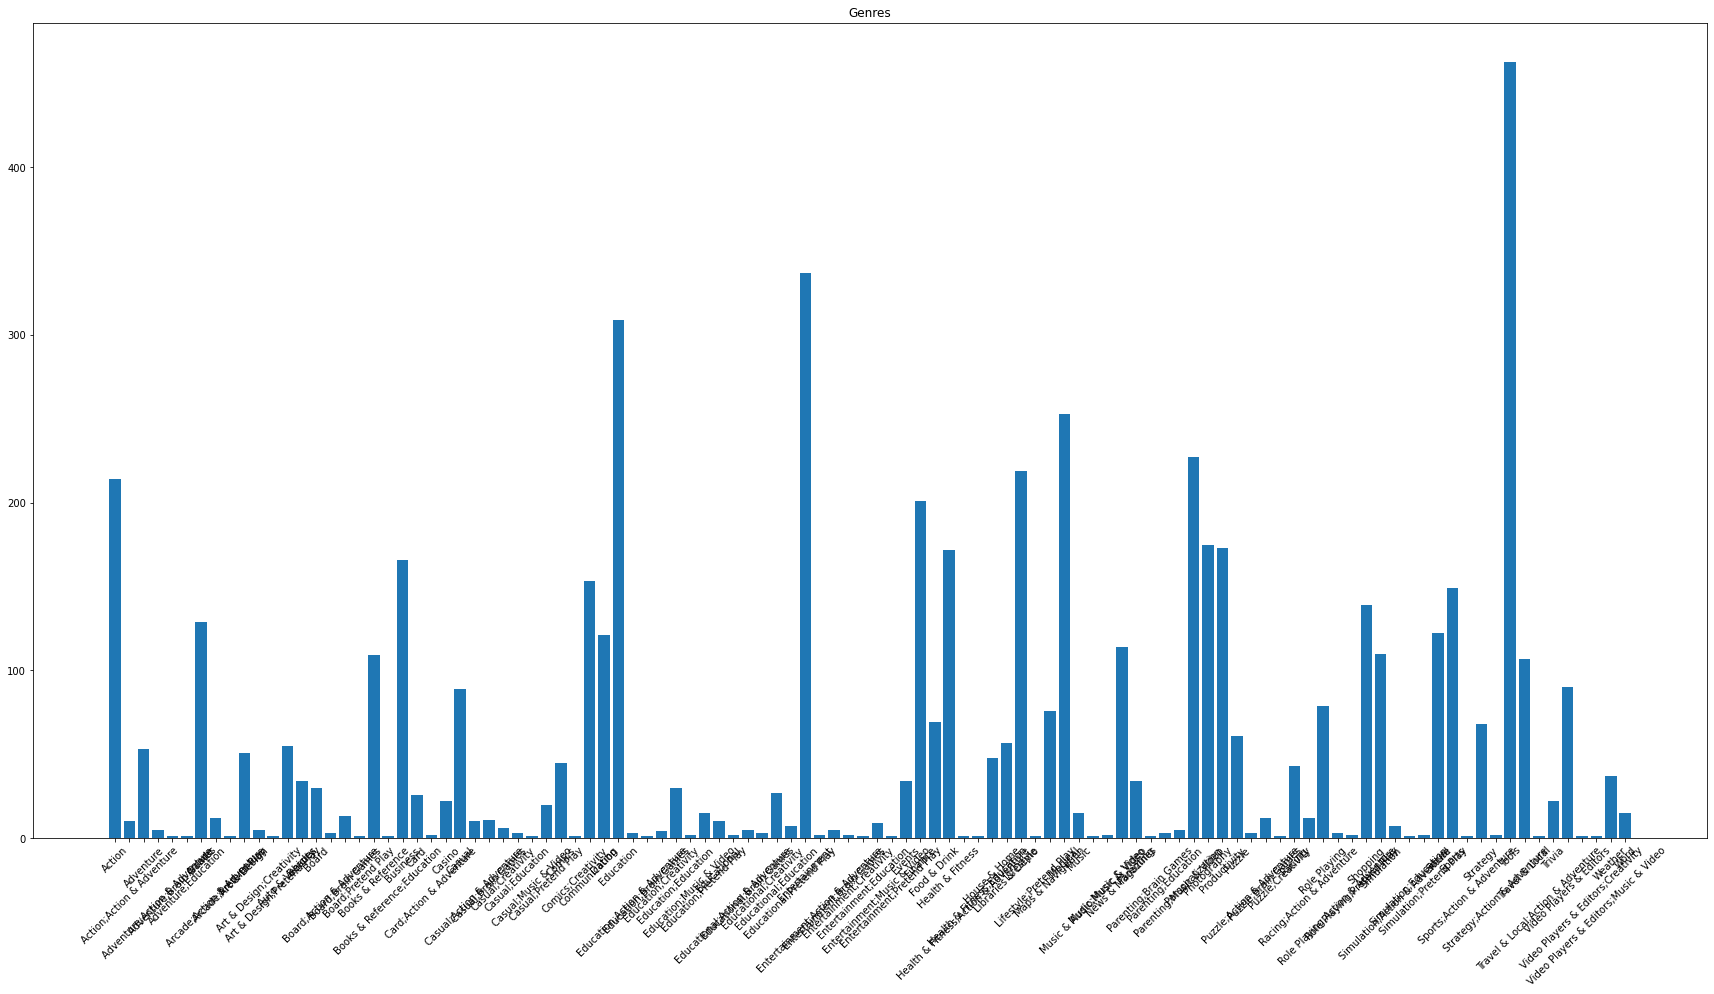

In [ ]:
grouped_data = all_train_data.groupby(['Genres'], as_index=False).count()
plt.figure(figsize = (30,15))
plt.bar(grouped_data['Genres'].values, grouped_data['Id'])
plt.title("Genres")
plt.xticks(rotation=45) 
plt.show()

앞서 말했듯 `Genres` 는 `Category` 의 하위 분야이기 때문에 실제 예측할 때는 사용하지 않으려 한다.

그래프로 확인해 볼 때도 매우 많은 수의 데이터들이 존재하는 것을 확인할 수 있다.

### Last Updated

- `Last Updated` 는 날짜를 나타내는 데이터이다.
- 최근 업데이트 날짜가 오래될 수록, 평점이 낮을 것으로 추측되기 때문에 사용해 보기로 했다.
- 날짜 객체를 숫자로 변환하여 사용해 보고자 한다.

In [ ]:
modified_updated = np.log(pd.to_datetime(all_train_data['Last Updated']).astype(int))

# 모두 datetime 객체로 변환한 뒤에 int로 변환하여 날짜별 고유번호를 불러온다.
# 수가 매우 크므로 로그변환을 취해준다.


In [ ]:
modified_updated

0       41.862134
1       41.862590
2       41.873812
3       41.870764
4       41.871442
          ...    
5611    41.862533
5612    41.860936
5613    41.865095
5614    41.868557
5615    41.873304
Name: Last Updated, Length: 5616, dtype: float64

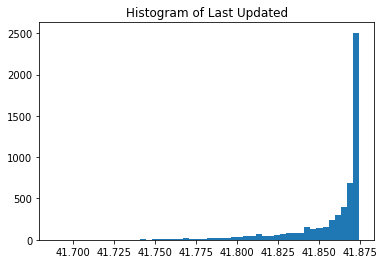

In [ ]:
plt.hist(modified_updated, bins=50)
plt.title("Histogram of Last Updated")
plt.show()

데이터가 우편향된 모습이 보인다.
최근에 업데이트 된 앱이 많기 때문으로 추정된다.

## 데이터 변환

앞선 과정을 통해 데이터에게 필요했던 처리를 정리하면 다음과 같다.

- 데이터의 이상치는 없다고 판단되어 따로 처리하지 않았다.
- 'App'의 경우 index변수라 판단되어 버리기로 했다.
- `Category`의 경우 총 개수가 33개로 판단, 적합하다고 생각되어 특별한 처리를 하지 않았다..
- `Rating`의 경우 예측변수로써 어떠한 처리도 하지 않았다.
- `Reviews` 의 경우 편차가 커서 로그 변환을 수행해 확인했다.
- `Size` 의 경우 편차가 커서 로그 변환을 수행해 확인했다.
- `Installs`의 경우 큰 수에서 반올림되어있기 때문에 범주형 변수로 취급하여 계산한다. 앞자리가 5인 계열에서 데이터가 들쑥날쑥한 모습이 보여 10 단위로 묶어서 계산했다. 다운로드 수가 1인 앱은 1+ 범례로 넣어 주었다.
- `Type`의 경우는 특별한 처리를 하지 않는다.
- `Price`의 경우 자리수가 매우 크기 때문에 로그 변환을 수행했다.
- `Content Rating` 의 경우는 특별한 처리를 하지 않는다.
- `Genres` 는 `Category` 와 겹치는 변수로 버리기로 했다.
- `Last Updated` 는 고유 번호로 변환하고 로그 변환을 수행했다.

위 과정을 수행하는 함수를 만들어 처리하겠다.


In [ ]:
def preprocess_data(data):

  # 특별한 처리를 하지 않는 Columns들
  nothing_modify = ['Category', 'Type', 'Content Rating']

  # 로그 변환 수행
  log_dfs = data[['Reviews', 'Size', 'Price']]

  # 다운로드 수를 범주형으로 변환한다.
  bins = [1*(10**i) for i in range(0,10)] # 1부터 1e9까지 구간 생성
  bin_label = [str(label) + '+' for label in bins] # 구간에 + 을 붙여 레이블 생성
  cut_installs = pd.cut(data["Installs"], bins = bins, include_lowest= True, labels=bin_label[:-1]) # 10의 지수배 구간으로 cutting
  
  # Last Updated를 고유번호로 변경하여 로그 변환을 수행한다.
  modified_last_updated = pd.Series(np.log(pd.to_datetime(data['Last Updated']).astype(int)))

  # 편집한 데이터를 모두 하나의 데이터프레임으로 변환한다.
  new_data = pd.concat([data[nothing_modify], log_dfs, cut_installs, modified_last_updated], axis=1)

  return new_data


In [ ]:
target = all_train_data["Rating"] # 타겟 변수 분리
tmp_x = all_train_data.drop("Rating", axis=1)

In [ ]:
train_x = preprocess_data(tmp_x)

In [ ]:
train_x # 데이터가 정상적으로 변환되었다.

,Category,Type,Content Rating,Reviews,Size,Price,Installs,Last Updated
0,ART_AND_DESIGN,0,Everyone,159,19.0,0.00,1000+,41.862134
1,ART_AND_DESIGN,0,Everyone,967,14.0,0.00,100000+,41.862590
2,ART_AND_DESIGN,0,Everyone,87510,8.7,0.00,1000000+,41.873812
3,ART_AND_DESIGN,0,Teen,215644,25.0,0.00,10000000+,41.870764
4,ART_AND_DESIGN,0,Everyone,967,2.8,0.00,10000+,41.871442
...,...,...,...,...,...,...,...,...
5611,GAME,0,Everyone,97209,6.7,0.00,100000+,41.862533
5612,FAMILY,0,Everyone,4518,41.0,0.00,100000+,41.860936
5613,GAME,0,Mature 17+,146,6.0,0.00,1000+,41.865095
5614,FAMILY,0,Everyone,3580,60.0,0.00,10000+,41.868557


In [ ]:
train_x.isnull().sum() # 특별한 오류가 없는 것을 확인할 수 있다.

Category          0
Type              0
Content Rating    0
Reviews           0
Size              0
Price             0
Installs          0
Last Updated      0
dtype: int64

## Scaling

더 고성능의 예측을 위해 데이터를 스케일링 하고자 한다.

Minmax 방법을 사용하려고 한다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler #스케일러 임포트

In [ ]:
# 수치형 변수 목록
numeric_data = ['Type', 'Reviews', 'Size', 'Price', 'Last Updated']

In [ ]:
scaler = MinMaxScaler()

scaled_train_x = train_x.copy()
scaled_train_x[numeric_data] = scaler.fit_transform(train_x[numeric_data]) # 수치형 변수들만 스케일링함

scaled_train_x

,Category,Type,Content Rating,Reviews,Size,Price,Installs,Last Updated
0,ART_AND_DESIGN,0.0,Everyone,3.519580e-06,0.189931,0.000000,1000+,0.935101
1,ART_AND_DESIGN,0.0,Everyone,2.151844e-05,0.139927,0.000000,100000+,0.937564
2,ART_AND_DESIGN,0.0,Everyone,1.949335e-03,0.086922,0.000000,1000000+,0.998174
3,ART_AND_DESIGN,0.0,Teen,4.803625e-03,0.249936,0.000000,10000000+,0.981711
4,ART_AND_DESIGN,0.0,Everyone,2.151844e-05,0.027917,0.000000,10000+,0.985374
...,...,...,...,...,...,...,...,...
5611,GAME,0.0,Everyone,2.165388e-03,0.066921,0.000000,100000+,0.937256
5612,FAMILY,0.0,Everyone,1.006199e-04,0.409950,0.000000,100000+,0.928630
5613,GAME,0.0,Mature 17+,3.229994e-06,0.059920,0.000000,1000+,0.951092
5614,FAMILY,0.0,Everyone,7.972517e-05,0.599966,0.000000,10000+,0.969790


## 상관관계 분석

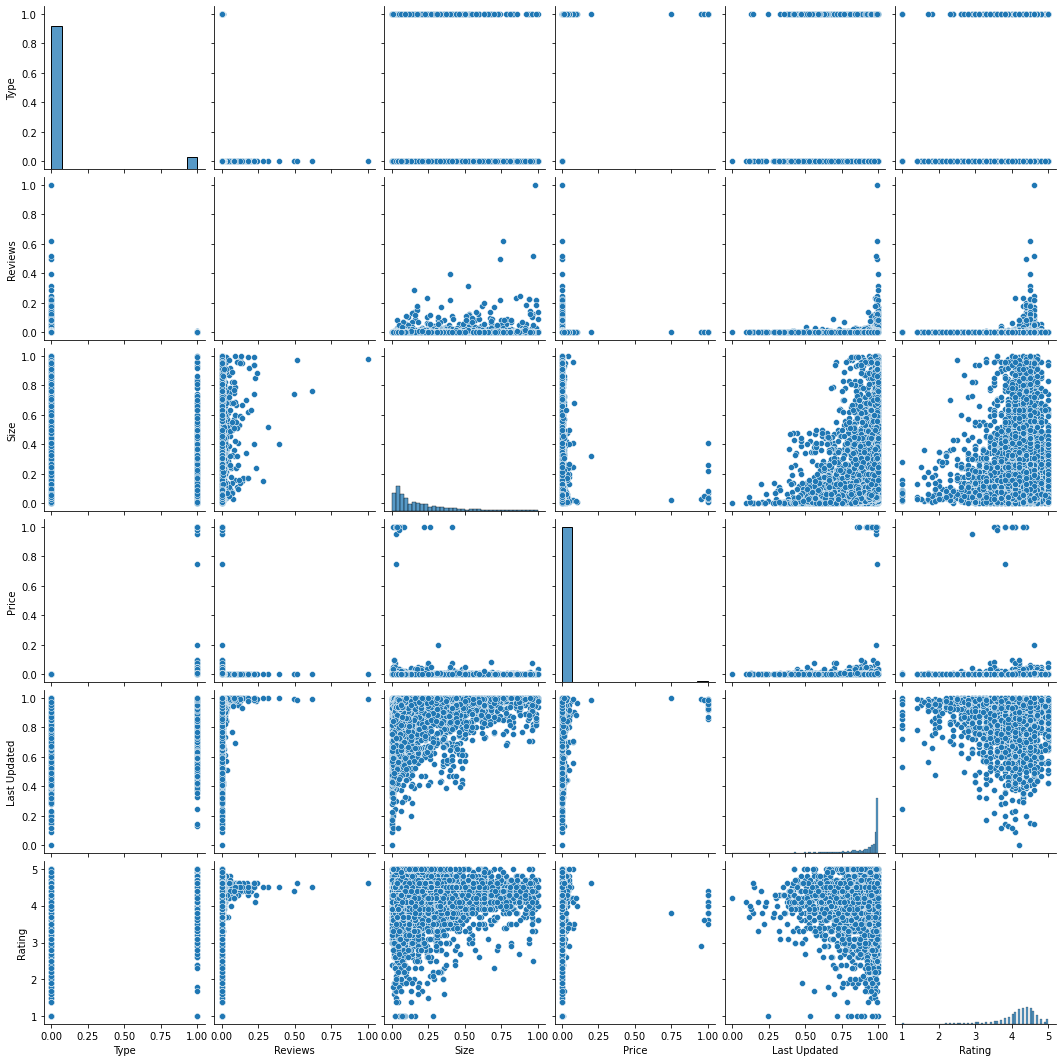

In [ ]:
# 산점도 표시
sns.pairplot(pd.concat([scaled_train_x[numeric_data], target], axis=1)) # 임시로 합쳐서 표시

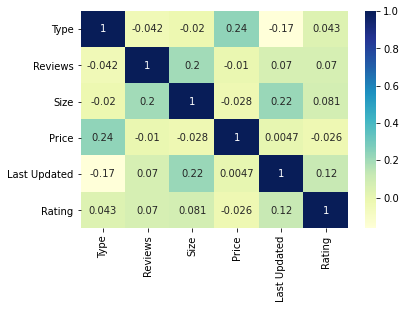

In [ ]:
# 상관관계로 히트맵 표시
sns.heatmap(pd.concat([scaled_train_x[numeric_data], target], axis=1).corr(),cmap = 'YlGnBu', annot=True) # annot를 사용해 숫자 표시.
plt.show()

큰 선형 관계 없이 데이터가 잘 정리된 것을 확인할 수 있었다.

## One-Hot 변환

범주형 변수 세 개를 One-Hot 방식으로 변환해 사용했다.

In [ ]:
def make_dummy(data):
  # 카테고리에 대한 더미 변수 생성
  category_dummy = pd.get_dummies(data["Category"], prefix='Category:')

  # Content Rating에 대한 더미 변수 생성
  content_dummy = pd.get_dummies(data['Content Rating'], prefix='AgeRating') # 알아보기 쉽게 AgeRating으로 변경..

  # Installs에 대한 더미 변수 생성
  install_dummy = pd.get_dummies(data["Installs"], prefix='Installs:')

  data = data.drop(['Category', 'Content Rating',"Installs"], axis=1)
  data = pd.concat([data, category_dummy, content_dummy, install_dummy], axis=1) # 데이터프레임에 연결한다.

  return data

In [ ]:
dummied_train_x = make_dummy(scaled_train_x)
dummied_train_x.head() # 성공적으로 변환되었다.

,Type,Reviews,Size,Price,Last Updated,Category:_ART_AND_DESIGN,Category:_AUTO_AND_VEHICLES,Category:_BEAUTY,Category:_BOOKS_AND_REFERENCE,Category:_BUSINESS,Category:_COMICS,Category:_COMMUNICATION,Category:_DATING,Category:_EDUCATION,Category:_ENTERTAINMENT,Category:_EVENTS,Category:_FAMILY,Category:_FINANCE,Category:_FOOD_AND_DRINK,Category:_GAME,Category:_HEALTH_AND_FITNESS,Category:_HOUSE_AND_HOME,Category:_LIBRARIES_AND_DEMO,Category:_LIFESTYLE,Category:_MAPS_AND_NAVIGATION,Category:_MEDICAL,Category:_NEWS_AND_MAGAZINES,Category:_PARENTING,Category:_PERSONALIZATION,Category:_PHOTOGRAPHY,Category:_PRODUCTIVITY,Category:_SHOPPING,Category:_SOCIAL,Category:_SPORTS,Category:_TOOLS,Category:_TRAVEL_AND_LOCAL,Category:_VIDEO_PLAYERS,Category:_WEATHER,AgeRating_Adults only 18+,AgeRating_Everyone,AgeRating_Everyone 10+,AgeRating_Mature 17+,AgeRating_Teen,AgeRating_Unrated,Installs:_1+,Installs:_10+,Installs:_100+,Installs:_1000+,Installs:_10000+,Installs:_100000+,Installs:_1000000+,Installs:_10000000+,Installs:_100000000+
0,0.0,0.000004,0.189931,0.0,0.935101,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.0,0.000022,0.139927,0.0,0.937564,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0.0,0.001949,0.086922,0.0,0.998174,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.0,0.004804,0.249936,0.0,0.981711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0.0,0.000022,0.027917,0.0,0.985374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


# 앙상블 학습

앙상블 학습은 여러 개의 모델을 활용해 머신 러닝의 학습 성과를 높이는 방법이다.

여러가지 앙상블 방법 중 수업에 나온 앙상블 방법들을 사용해 보고자 한다.

In [ ]:
# 예측 모델 패키지 임포트
import sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV# 모델 평가에 사용
from sklearn.metrics import mean_squared_error # 모델 평가에 사용

from sklearn.linear_model import LinearRegression # 평점은 연속형 확률변수이므로 선형 회귀를 사용한다.
from sklearn.tree import DecisionTreeRegressor # DecisionTree로도 Regression처럼 사용할 수 있다.
from sklearn.neighbors import KNeighborsRegressor # KNN 알고리즘으로 Regression을 사용할 수 있다.
from sklearn.svm import SVR # Regression 용 SVM.

예측 변수 `Rating` 은 연속형 범주이므로, 회귀 분석이 가능한 모델들을 임포트 해야 한다.

사용된 모델은 다음과 같다.
- 선형 회귀모델
- Decision Tree
- KNN
- SVM

나이브 베이즈 모델의 경우에는 연속형 범주의 회귀 분석이 불가능하므로(로지스틱 회귀와 유사) 사용하지 못했다.

과제의 평가지표가 RMSE 이므로 `mean_squared_error` 을 임포트했다. `squared` 속성을 `False` 로 설정하면 RMSE 가 나온다.

## 데이터 분할

train데이터를 validation 과 분할해 모델을 평가할 준비를 한다.

train 과 test 데이터의 비가 4 : 1 이므로, Test데이터는 전체의 20%로 추정, 같은 양을 맞추기 위해 validation은 train에서 25%를 분리하겠다.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(dummied_train_x, target, test_size=0.25, random_state=0)

In [ ]:
print(f"shape of x_train{x_train.shape}")
print(f"shape of y_train{y_train.shape}")
print(f"shape of x_val{x_val.shape}")
print(f"shape of y_val{y_val.shape}")

shape of x_train(4212, 53)
shape of y_train(4212,)
shape of x_val(1404, 53)
shape of y_val(1404,)


## 개별 모델 평가


In [ ]:
linearModel = LinearRegression() # 선형회귀모델
linearModel.fit(x_train, y_train)
prediction = linearModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5320512607957902


In [ ]:
dtModel = DecisionTreeRegressor(random_state=0) # Decision Tree
dtModel.fit(x_train, y_train)
prediction = dtModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.728641752453703


In [ ]:
knnModel = KNeighborsRegressor() # KNN
knnModel.fit(x_train, y_train)
prediction = knnModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5583563587547145


In [ ]:
svmModel = SVR() # SVM
svmModel.fit(x_train, y_train)
prediction = svmModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5407153567159482


각 모델별로 성능이 비슷하다.

Decision Tree 모델만 0.72정도의 RMSE 를 보이고, 나머지 모델은 0.52정도의 RMSE를 보인다.

## 개별 모델의 하이퍼파라미터 튜닝

각 모델별로 최고의 성능을 보이는 하이퍼파라미터를 찾는다.
GridSearch 알고리즘을 사용할 것이다.

### Linear Regression 모델 튜닝
선형 회귀 모형은 정해진 계산 식에 따라 모든 수식이 계산되므로 튜닝할 필요가 없다.

### Decision Tree 튜닝
다음 파라미터를 튜닝하고자 한다.
- criterion (평가방식 변화)
- max_depth (오버피팅 방지)

In [ ]:
grid_params = {
    'criterion': ["mse", "friedman_mse", "mae"],  # MSE, friedman의 MSE, L1노름을 사용하는 MAE
    'max_depth': [i for i in range(1, 51, 10)] # 1부터 50까지 10의 간격으로 확인
}

In [ ]:
grid_model = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state=0),
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', # RMSE 를 평가 지표로 삼겠다.
    n_jobs=-1, # -1 인경우 모든 cpu 코어를 다 사용해서 계산한다(계산 속도가 빨라진다)
    cv = 5, # 5-fold cross validation을 사용하겠다.
    verbose=3, # 계산 시간과 점수(정확도) 를 표시한다.
    return_train_score = True,
    error_score = "raise" # 오류가 나면 서치를 종료하고 오류 Raise
)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   25.1s finished


GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 11, 21, 31, 41]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tr

In [ ]:
grid_model.best_params_ # 가장 결과가 좋았던 파라미터 반환

{'criterion': 'mse', 'max_depth': 1}

In [ ]:
# 모델 평가
dtModel = DecisionTreeRegressor(random_state=0, criterion='mse', max_depth=1)
dtModel.fit(x_train, y_train)
prediction = dtModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5439707964905134


기존 0.72에서 눈에 띄게 감소한 것을 확인할 수 있다.

### KNN 튜닝

다음 파라미터를 튜닝했다.
- n_neighbors : 근접한 이웃의 개수. 평가를 위해 홀수만 생성하겠다.
- weights : 거리에 따른 가중치 사용 여부
- metric : 거리 계산 방식

In [ ]:
grid_params = {
    'n_neighbors': [i for i in range(1, 20, 2)], # 1부터 20까지 홀수만 생성
    'metric': ['euclidean', 'manhattan'], # 다양한 거리 계산 방식 사용
    'weights': ['uniform', 'distance'] # 가중치 여부
}

In [ ]:
grid_model = GridSearchCV(
    estimator = KNeighborsRegressor(),
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1,
    cv = 5, 
    verbose=3, 
    return_train_score = True,
    error_score = "raise" 
)
grid_model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
grid_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}

In [ ]:
# 모델 평가
knnModel = KNeighborsRegressor(metric='manhattan', n_neighbors=17, weights='uniform')
knnModel.fit(x_train, y_train)
prediction = knnModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5345194506189048


기존 0.5584에서 아주 약간 감소한 것을 확인할 수 있다.

### SVM 튜닝

다음 파라미터를 튜닝한다.
- gamma
- C

In [ ]:
grid_params = {
    'gamma': [i for i in range(1, 11)],
    'C': [i for i in range(1, 100, 10)]
}

In [ ]:
grid_model = GridSearchCV(
    estimator = SVR(),
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1,
    cv = 5, 
    verbose=3, 
    return_train_score = True,
    error_score = "raise" 
)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 25.6min finished


GridSearchCV(cv=5, error_score='raise',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91],
                         'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
grid_model.best_params_

{'C': 1, 'gamma': 1}

In [ ]:
# 모델 평가
svmModel = SVR(C=1, gamma=1)
svmModel.fit(x_train, y_train)
prediction = svmModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.552022329517148


기존에 0.540에서 약간 증가한 것으로 확인된다.

C의 기본값은 1이라 별로 차이가 없지만, gamma의 값이 'scale'에서 변경되었기 때문으로 추정된다. 

따라서 따로 튜닝 없이 기본 파라미터를 사용하는 것으로 결정했다.


In [ ]:
# 모델 평가
svmModel = SVR()
svmModel.fit(x_train, y_train)
prediction = svmModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5407153567159482


## Voting
보팅은 여러 개의 모델이 투표를 통해서 결정하는 방법이다.

하드 보팅 (단순 투표)과 소프트 보팅(값의 평균) 두 가지 방법이 있다.

이 예시와 같은 Regression 에서는 투표를 통해 카테고리를 계산하지 못한다.

따라서 Voting의 경우 여러 개의 모델이 낸 값을 평균내서 계산한다고 [공식 사이트](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) 에서 설명하고 있다.

In [ ]:
from sklearn.ensemble import VotingRegressor # Voting 회귀모델 import

In [ ]:
votingModel = VotingRegressor(
    estimators=[('Linear', linearModel), ('dtModel', dtModel), ('knnModel', knnModel), ('svmModel', svmModel)]
) # Regression 모델에선 하드/소프트 보팅 방법을 선택하지 않는다.

votingModel.fit(x_train, y_train)

VotingRegressor(estimators=[('Linear',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False)),
                            ('dtModel',
                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse', max_depth=1,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   pre...
                                       

In [ ]:
prediction = votingModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5259882813614996


RMSE가 0.526 정도로 약간 하락한 것을 확인할 수 있다.

RMSE는 낮을 수록 좋은 것이므로 성능이 조금 상승한 것으로 해석가능하다.

## Bagging

Bagging은 전체 데이터에서 일부 subsets을 복원 추출하여 그 데이터의 예측값을 결합한 값을 모델의 예측값으로 사용하는 방법이다.

BaggingRegressor의 주요 파라미터는 다음과 같다.
- base_estimator : 데이터에 적용할 기본 모델
- n_estimators : 몇 개의 데이터셋을 추출한 것인가를 결정
- bootstrap : True면 복원추출. False면 비복원추출
- max_samples: 추출할 샘플의 수
- max_features : 추출할 feature의 수 (다차원 데이터에서?)

우선 기본 파라미터로 모델을 생성한 뒤 확인해보았다.

기본 트리는 Decision Tree 를 활용한 결정 모델이다.

In [ ]:
# Bagging 모델 임포트
from sklearn.ensemble import BaggingRegressor

In [ ]:
baggingModel = BaggingRegressor()
baggingModel.fit(x_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
# 모델 평가
prediction = baggingModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.567849663855444


0.5678 정도로 높은 수치를 보인다.

하이퍼파라미터 튜닝을 통해 연산이 가능한지 확인해 보려 한다.

튜닝은 위와 같이 그리드 서치 알고리즘으로 체크한다.

튜닝 할 파라미터는 다음과 같다
- base_estimator : DT이외에도 지금까지 썼던 모델 중 더 높은 성능을 보이는 모델이 있는지 체크
- n_estimators : 판단기의 수에 따른 정확도 체크
- max_samples : 총 몇 개의 데이터를 뽑을 것인가.
- max_features : 몇 개의 피처를 뽑을 것인가.

In [ ]:
grid_params = {
    'base_estimator': [None, linearModel, dtModel, svmModel], # KNN모델은 n_estimator 의 크기 때문에 오류가 난다.
    'n_estimators': [i for i in range(1, 21)], # 1부터 20까지의 수로 계산
    'max_samples': [i for i in range(1, 11)], # 1부터 10까지의 수로 계산
    'max_features': [i for i in range(1, 6)] # 1부터 5까지의 수로 계산
}

In [ ]:
grid_model = GridSearchCV(
    estimator = BaggingRegressor(random_state=0), # 차후를 위해 랜덤값을 고정
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1,
    cv = 5, 
    verbose=3, 
    return_train_score = True,
    error_score = "raise" 
)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 826 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 2106 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6202 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9018 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 12346 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 16186 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 20000 out of 20000 | elapsed:  7.5min finished


GridSearchCV(cv=5, error_score='raise',
             estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
                                        bootstrap_features=False,
                                        max_features=1.0, max_samples=1.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'base_estimator': [None,
                                            LinearRegression(copy_X=True,
                                                             fit_intercept=...
                                                coef0=0.0, degree=3,
                                                epsilon=0.1, gamma='scale',
                                                kernel='rbf', max_iter=-1,
                                                shrinking=True, 

In [ ]:
grid_model.best_params_

{'base_estimator': None,
 'max_features': 4,
 'max_samples': 2,
 'n_estimators': 20}

In [ ]:
baggingModel = BaggingRegressor(base_estimator=None, max_samples=2, n_estimators=20, max_features=4, oob_score=True, random_state=0) # oob_score를 계산한다
baggingModel.fit(x_train, y_train)
# 모델 평가
prediction = baggingModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5492873037152707


기본 파라미터를 쓴 단순 모델에 비해 성능이 향상된 것을 확인할 수 있다.

하지만 완전히 좋은 모델은 아닌 것으로 추측된다.

Bagging은 복원 추출 특성상 out-of-bag (한번도 선택되지 않은 데이터) 을 가지고 있다.

이 데이터들은 모델이 한 번도 본 적 없는 데이터이기 때문에 Validation값으로 사용될 수 있다.

이 경우 validation이 따로 필요 없기 때문에 split전 데이터로 따로 학습을 시키는 실험을 해 보았다.

학습에 사용되는 데이터가 더 커졌기 때문에 모델의 예측 성능이 더 좋아질 것으로 예측이 가능하다.

In [ ]:
bigger_baggingModel = BaggingRegressor(base_estimator=None, max_samples=2, n_estimators=20, max_features=4, oob_score=True, random_state=0)
bigger_baggingModel.fit(dummied_train_x, target)

print(f"oob_score: {baggingModel.oob_score_}")
print(f"bigger_oob_score: {bigger_baggingModel.oob_score_}")

oob_score: 0.0018691067092259095
bigger_oob_score: -0.07626337747891032


oob_score_ 는 coefficient 를 계산한다고 나와 있다.

0에 가까울수록 모델이 예측을 잘 한것으로 볼 수 있다고 한다.
[출처](https://stats.stackexchange.com/questions/133406/is-a-negative-oob-score-possible-with-scikit-learns-randomforestregressor)

`bigger_baggingModel` 의 경우 oob_score가 기존 모델보다 더 벌어진 것을 확인할 수 있었다.

## Random Forest

Random Forest 는 Decision Tree 여러 개를 복원추출하여 계산하는 앙상블 기법이다.

추출된 데이터의 Feature를 정해진 개수만큼 뽑아 계산한다.

위 문제와 같은 Regression 에서는 여러 개의 estimator의 평균을 내어 계산한다고 한다.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# 기본 파라미터로 확인
rfModel = RandomForestRegressor(random_state=0) # 100 개의 DT모델, mse 평가, max_depth : 무제한, 
rfModel.fit(x_train, y_train)

prediction = rfModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5466150044201377


기본 파라미터로 진행했을때 RMSE는 0.5466 정도가 나왔다.

이전과 똑같이 GridSearch를 이용해 하이퍼파라미터 튜닝을 해보고자 한다.

튜닝할 하이퍼파라미터는 다음과 같다.

- n_estimators : 총 예측기 개수
- max_depth : 트리의 최대 깊이를 체크.

In [ ]:
grid_params = {
    'n_estimators' : [i for i in range(10, 201, 10)], # 10부터 200까지 10간격으로
    'max_depth': [None, 10, 20, 30, 40, 50] # 10~ 50까지와 무제한
}

In [ ]:
grid_model = GridSearchCV(
    estimator = RandomForestRegressor(random_state=0), # 차후를 위해 랜덤값을 고정
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1,
    cv = 5, 
    verbose=3, 
    return_train_score = True,
    error_score = "raise" 
)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 16.7min finished


GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [ ]:
grid_model.best_params_

{'max_depth': 20, 'n_estimators': 200}

In [ ]:
forestModel = RandomForestRegressor( max_depth=20, n_estimators=200, oob_score=True, random_state=0) # oob_score를 계산한다
forestModel.fit(x_train, y_train)
prediction = forestModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5402847962337806


성능이 약간 상능한 것을 확인할 수 있었다.

In [ ]:
bigger_forestModel = RandomForestRegressor(max_depth=20, n_estimators=200, oob_score=True, random_state=0)
bigger_forestModel.fit(dummied_train_x, target)

print(f"oob_score: {forestModel.oob_score_}")
print(f"bigger_oob_score: {bigger_forestModel.oob_score_}")

oob_score: 0.1190080946537787
bigger_oob_score: 0.09714486300768166


위와 마찬가지로 oob 를 validation data 로 활용하여 모델을 평가해 보았고, 이에 따라 더 큰 데이터로 모델을 학습시켜 보았다.

OOB score를 확인해 볼때 두 모델의 큰 차이는 없었다.


## Boosting

Boosting 은 약한 학습기 여러개를 순차적으로 학습하는 방법이다.

잘못 예측한 데이터에 가중치를 부여해서 다음 예측에 이용한다.

### Adaboost

가장 기본적인 Boosting 학습모델이다.

여러 개의 분류기에 각각 가중치를 곱해 최종 결과값을 내는 방식이다.

![이미지](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FmLFPn%2FbtqDf1V1Fjk%2FgaIjblBLu1lIMEPF0kKDO0%2Fimg.png)

In [ ]:
# 에이다부스트 임포트
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
adaModel = AdaBoostRegressor(random_state=0)
# 기본 파라미터로 학습 진행
# DecisionTreeRegressor(max_depth = 3)
# n_estimators = 50
# learning_rate = 1 으로 진행됨

adaModel.fit(x_train, y_train)
prediction = adaModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.6436134253027032


0.6436으로 상당히 높은 오류를 보이고 있다.

하이퍼파라미터 튜닝을 실시해 보겠다.

튜닝할 파라미터는 다음과 같다.
- base_estimator : DecisionTree 의 조정에 따른 성과 지표 차이
- n_estimators : estimators의 개수에 따른 정확도 분석
- learning_rate : 조정에 따른 정확도 분석

In [ ]:
grid_params = {
    "base_estimator" : [DecisionTreeRegressor(max_depth=None),DecisionTreeRegressor(max_depth=1),DecisionTreeRegressor(max_depth=2),DecisionTreeRegressor(max_depth=3),DecisionTreeRegressor(max_depth=4)],
    "n_estimators": [i for i in range(20, 61, 10)], # 20, 30, 40, 50, 60
    "learning_rate" : [i * 0.1 for i in range(1, 11, 1)] # 0.1 ~ 1까지
}

In [ ]:
grid_model = GridSearchCV(
    estimator = AdaBoostRegressor(random_state=0), # 차후를 위해 랜덤값을 고정
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1,
    cv = 5, 
    verbose=3, 
    return_train_score = True,
    error_score = "raise" 
)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  7.1min finished


GridSearchCV(cv=5, error_score='raise',
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeRegressor(ccp_alpha=0.0,
                                                                  criterion='mse',
                                                                  max_depth=None,
                                                                  max_features=None,
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                                                                  min_samples_split=2,
                          

In [ ]:
grid_model.best_params_

{'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 'learning_rate': 0.1,
 'n_estimators': 20}

In [ ]:
# 튜닝된 파라미터로 학습
adaModel = AdaBoostRegressor(base_estimator= DecisionTreeRegressor(max_depth=4), learning_rate=0.1, n_estimators=24, random_state=0)
adaModel.fit(x_train, y_train)
prediction = adaModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5432703945185056


learning_rate 를 수정해 가다 보니 결과 값이 더 좋아지는 것을 확인했다.

다른 값은 그대로 두고, learning_rate와 n_estimators에 대해서 범위를 좁혀서 다시 튜닝을 시도했다.

In [ ]:
grid_params = {
    "n_estimators": [i for i in range(10, 31, 1)],
    "learning_rate" : [i * 0.01 for i in range(1, 11, 1)] # 0.01 ~ 0.121까지
}

In [ ]:
grid_model = GridSearchCV(
    estimator = AdaBoostRegressor(base_estimator= DecisionTreeRegressor(max_depth=4), random_state=0), # 차후를 위해 랜덤값을 고정
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1,
    cv = 5, 
    verbose=3, 
    return_train_score = True,
    error_score = "raise" 
)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise',
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                              criterion='mse',
                                                                              max_depth=4,
                                                                              max_features=None,
                                                                              max_leaf_nodes=None,
                                                                              min_impurity_decrease=0.0,
                                                                              min_impurity_split=None,
                                                                              min_samples_leaf=1,
                                                                              min_samples_split=2,
                                                                              mi

In [ ]:
grid_model.best_params_

{'learning_rate': 0.03, 'n_estimators': 16}

In [ ]:
# 한번 더 튜닝된 파라미터로 학습
adaModel = AdaBoostRegressor(base_estimator= DecisionTreeRegressor(max_depth=4), learning_rate=0.03, n_estimators=16, random_state=0)
adaModel.fit(x_train, y_train)
prediction = adaModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5349942118181524


상당히 많이 개선된 것을 확인할 수 있었다.

### Gradient Boost

그라디언트 부스트는 에이다부스트와 같이 여러 개의 모델을 이용해 순차적으로 학습하는 것은 같다.

하지만 오차를 이용해 target 함수의 Gradient를 전파하는 방법으로 학습을 진행하는 차이가 있다.

In [ ]:
# 기본 Gradient Boost 임포트
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gradModel = GradientBoostingRegressor(random_state=0)
# 기본 파라미터로 생성
# learning rate = 0.1
# n_estimators = 100
# max_depth = 3
gradModel.fit(x_train, y_train)
prediction = gradModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5239861066814693


지금까지 모델 중 오차가 가장 낮게 나오는 것을 확인할 수 있었다.

마찬가지로 그리드서치를 통해 하이퍼파라미터를 튜닝해 보도록 하겠다.

튜닝할 파라미터는 다음과 같다.
- learning_rate
- n_estimators
- max_depth

Adaboost의 값을 참고하여 범위를 설정했다.

In [ ]:
grid_params = {
    "n_estimators": [i for i in range(100, 201, 10)],
    "learning_rate" : [i * 0.01 for i in range(1, 21, 1)], # 0.01 ~ 0.2까지
    "max_depth": [i for i in range(1, 5)] # 1~5까지
}

In [ ]:
grid_model = GridSearchCV(
    estimator = GradientBoostingRegressor(random_state=0), # 차후를 위해 랜덤값을 고정
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1,
    cv = 5, 
    verbose=3, 
    return_train_score = True,
    error_score = "raise" 
)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 880 candidates, totalling 4400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 2044 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 3868 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 4400 out of 4400 | elapsed: 40.3min finished


GridSearchCV(cv=5, error_score='raise',
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_it...
                            

In [ ]:
grid_model.best_params_

{'learning_rate': 0.17, 'max_depth': 2, 'n_estimators': 160}

In [ ]:
# 개선된 파라미터 예측
gradModel = GradientBoostingRegressor(learning_rate =  0.17, max_depth =  2, n_estimators= 160, random_state=0)
gradModel.fit(x_train, y_train)
prediction = gradModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5199962965530353


지금까지 나온 모델 중 가장 낮은 RMSE 를 보인 것을 확인할 수 있다.

### XGBoost

xgboost 는 GradientBoost의 속도를 개선한 모델이다.

다이나믹한 결과의 개선은 기대되지 않기 때문에, 기본 파라미터와 GB모델의 파라미터로만 결과를 확인하겠다.

In [ ]:
# xgb 패키지 임포트 
from xgboost import XGBClassifier
import xgboost as xgb

In [ ]:
# 일반 xgb
xgbModel = XGBClassifier(random_state=0)
xgbModel.fit(x_train, y_train)
prediction = xgbModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.6208738442585019


In [ ]:
# GB에 튜닝된 파라미터로 튜닝
xgbModel2 = XGBClassifier(learning_rate =  0.17, max_depth =  2, n_estimators= 160, random_state=0)
xgbModel2.fit(x_train, y_train)
prediction = xgbModel2.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.6423669727152288


성능이 크게 높게 나오지는 않는 것으로 보인다.

### LightGBM(LGBM)

트리를 한 쪽만 성장시켜 학습 시간과 오류 손실을 최소화할 수 있다.

In [ ]:
# 패키지 import
from lightgbm import LGBMRegressor

In [ ]:
# 기본 모델
lgbModel = LGBMRegressor(random_state=0)
lgbModel.fit(x_train, y_train)
prediction = lgbModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5265861730884955


간단하게 파라미터 튜닝을 진행했다.

튜닝을 진행할 파라미터는 다음과 같았다.
- learning_rate
- n_estimator

In [ ]:
grid_params = {
    "n_estimators": [i for i in range(100, 201, 10)],
    "learning_rate" : [i * 0.01 for i in range(1, 11, 1)], # 0.01 ~ 0.1까지
}

In [ ]:
grid_model = GridSearchCV(
    estimator = LGBMRegressor(random_state=0), # 차후를 위해 랜덤값을 고정
    param_grid = grid_params,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1,
    cv = 5, 
    verbose=3, 
    return_train_score = True,
    error_score = "raise" 
)
grid_model.fit(x_train, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=0,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.07, 0.08, 0.09, 0.1],
                         'n_estimat

In [ ]:
grid_model.best_params_

{'learning_rate': 0.04, 'n_estimators': 100}

In [ ]:
# 개선된 파라미터 예측
lgradModel = LGBMRegressor(learning_rate =  0.04, n_estimators= 100, random_state=0)
lgradModel.fit(x_train, y_train)
prediction = lgradModel.predict(x_val)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5184055893583588


## 정리

지금까지 생성한 모델들의 RMSE를 정리하면 다음과 같다.

Basic Models
- Linear Regression : 0.5320512607957902
- Decision Tree : 0.5439707964905134
- KNN : 0.5345194506189048
- SVM : 0.5407153567159482

Ensemble Models
- Voting : 0.5259882813614996
- Bagging : 0.5492873037152707
- Random Forest : 0.5402847962337806
- Adaboost : 0.5349942118181524
- Gradient Boost : 0.5199962965530353
- XGBoost : 0.6208738442585019
- LGBM : 0.5184055893583588

대부분의 모델의 정확도가 0.52~0.55 정도에서 유지되는 것을 볼 수 있었다.

## Stacking

스태킹은 여러 개의 모델을 사용해 예측 결과를 도출하고, 그 결과를 가지고 다시 예측해 결과를 예측하는 앙상블 기법이다.

정확도가 높아지는 경향이 있어 캐글 경진대회에서 많이 사용한다고 한다.

![스태킹](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcM3MVi%2FbtqF3GahzmF%2FXJjnJf0pUiUkJs0nSEc4y1%2Fimg.png)

### Basic Stacking

basic Stacking은 위에 적힌 이미지 대로 모델들의 예측결과를 그대로 최종 예측기의 input 데이터로 넣는 방법.

과적합의 위험이 있어서 잘 사용하지는 않는다

Basic Stacking 코드는 공부를 위해 라이브러리를 사용하지 않고, 강의자료를 참고하여 수동으로 작성했다.

사용하는 모델은 앞서 사용한 모델 중 성능이 좋았던 모델을 사용했다.

In [ ]:
# Stacking 에 사용하기 위해 train 데이터를 다시 나눠야 한다.
# 실제 validation(평가용) 데이터와 개수를 맞추기 위해 0.3333... 으로 분할한다.

x_stack_train, x_stack_val, y_stack_train, y_stack_val = train_test_split(x_train, y_train, test_size=0.333333, random_state=0)

In [ ]:
print(f"shape of x_stack_train : {x_stack_train.shape}")
print(f"shape of x_stack_val : {x_stack_val.shape}")
print(f"shape of y_stack_train : {y_stack_train.shape}")
print(f"shape of y_stack_val : {y_stack_val.shape}")

print(f"shape of x_val : {x_val.shape}")


shape of x_stack_train : (2808, 53)
shape of x_stack_val : (1404, 53)
shape of y_stack_train : (2808,)
shape of y_stack_val : (1404,)
shape of x_val : (1404, 53)


In [ ]:
# 개별 모델들 새로 생성
s_linearModel = LinearRegression() # 선형회귀
s_knnModel = KNeighborsRegressor(metric='manhattan', n_neighbors=17, weights='uniform') # knn
s_svmModel = SVR() #SVM
s_forestModel = RandomForestRegressor( max_depth=20, n_estimators=200, oob_score=True, random_state=0) # Random Forest

stackingModels = [s_linearModel, s_knnModel, s_svmModel, s_forestModel]

In [ ]:
# 개별 모델들의 학습
prediction = []
for model in stackingModels: # 모델들을 순회하며 반복문을 실행
  model.fit(x_stack_train, y_stack_train) # 각 모델을 학습한다.
  pred = model.predict(x_stack_val) # 각 모델의 예측값 생성
  print(f"RMSE of {type(model).__name__}: {mean_squared_error(y_stack_val, pred, squared=False)}") # RMSE 표시
  prediction.append(pred) # 결과값 저장

RMSE of LinearRegression: 0.5107047166612323
RMSE of KNeighborsRegressor: 0.5124376990715707
RMSE of SVR: 0.5170564942687429
RMSE of RandomForestRegressor: 0.5073258484799479


In [ ]:
# 각 예측의 결과는 배열로 저장된다.
# (4 개의 모델에서 예측된 1404개의 값을 가짐)
# 다음 모델에 입력하기 위해 Transpose를 해 주어야 함
prediction = np.array(prediction).T # Transpose 한 값을 저장

In [ ]:
prediction.shape

(1404, 4)

In [ ]:
# 최종 모델은 LGBM 모델을 사용하겠다.
s_lgradModel = LGBMRegressor(learning_rate =  0.04, n_estimators= 100, random_state=0)
s_lgradModel.fit(prediction, y_stack_val)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.04, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 테스트 코드로 x_val을 사용한다.
# 앞 과정을 다시 수행한다.

prediction = []
for model in stackingModels: 
  pred = model.predict(x_val) 
  prediction.append(pred)

prediction = np.array(prediction).T
stack_pred = s_lgradModel.predict(prediction)

print(f"RMSE: {mean_squared_error(y_val, stack_pred, squared=False)}") # RMSE 표시

RMSE: 0.5359765672755966


실제 모델의 RMSE는 그렇게 높게 나오지는 않았다.

데이터의 수가 적기 때문에 과적합이 나타난 것으로 추정된다.

### Cross validation 기반 Stacking

오버핏 문제를 해결하기 위한 방법 중 하나이다.

각 데이터를 fold로 나눠서(CV) 각 폴드를 기반으로 모델을 학습한다.

과제 코드를 참고해서 작성했다.

In [ ]:
# 개별 모델들 새로 생성
cv_linearModel = LinearRegression() # 선형회귀
cv_knnModel = KNeighborsRegressor(metric='manhattan', n_neighbors=17, weights='uniform') # knn
cv_svmModel = SVR() # SVM
cv_forestModel = RandomForestRegressor( max_depth=20, n_estimators=200, oob_score=True, random_state=0) # Random Forest

stackingModels = [cv_linearModel, cv_knnModel, cv_svmModel, cv_forestModel]

In [ ]:
# Kfold 용 모듈 임포트
from sklearn.model_selection import KFold

In [ ]:
# CV stacking 데이터를 추출하는(1차 Stack) 모델 사용
def get_stacked_data(model, x_train, y_train, x_test, n_folds=5):
  kfold = KFold(n_splits= n_folds)

  # 예측에 사용할 배열을 미리 초기화 해 둠.(학습 데이터를 채워 넣는 방식으로 사용해야하기 때문)
  train_fold_pred = np.zeros((x_train.shape[0], 1)) # 전체 train 데이터의 크기만큼의 길이를 가진 데이터 생성
  test_pred = np.zeros((x_val.shape[0], n_folds)) 

  print(f"Use Model {type(model).__name__}")

  # 폴드를 사용한 반복 시작
  for cnt, (train_i, val_i) in enumerate(kfold.split(x_train)):

    x_train_ = x_train[train_i] # train_i 에는 이번 fold의 인덱스가 저장되어 있다.
    y_train_ = y_train[train_i]

    x_val_ = x_train[val_i]

    # fold 학습
    model.fit(x_train_, y_train_)

    # 실제 다음 단계의 예측으로 사용되는 부분은 validation 부분이다.
    # 따라서 결과 반환을 위해 예측 실시
    train_fold_pred[val_i, :] = model.predict(x_val_).reshape(-1,1) # 데이터 저장

    # 정확도 계산을 위해 데이터
    test_pred[:, cnt] = model.predict(x_test)

  # 반복이 끝나면 test 데이터의 평균을 구한다.
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  return train_fold_pred, test_pred_mean

In [ ]:
train_result = np.zeros((len(x_train), len(stackingModels)))
test_result = np.zeros((len(x_val), len(stackingModels)))

for model in stackingModels:
  train, test = get_stacked_data(model, x_train.to_numpy(), y_train.to_numpy(), x_val.to_numpy(), 5)
  train_result += train
  test_result += test

Use Model LinearRegression
Use Model KNeighborsRegressor
Use Model SVR
Use Model RandomForestRegressor


In [ ]:
print(f"shape of train_result : {train_result.shape}")
print(f"shape of test_result : {test_result.shape}")

shape of train_result : (4212, 4)
shape of test_result : (1404, 4)


In [ ]:
cv_lgradModel = LGBMRegressor(learning_rate =  0.04, n_estimators= 100, random_state=0)
cv_lgradModel.fit(train_result, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.04, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
prediction = cv_lgradModel.predict(test_result) # 결과 예측
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}") # RMSE 표시

RMSE: 0.5282880142913002


### CV 기반 Stacking 모델 튜닝

여러가지 모델을 섞어서 성능이 잘 나오는지를 확인해 보았다.

`vecstack` 패키지는 stacking 을 빠르고 편리하게 사용할 수 있는 기능을 제공한다.

In [ ]:
# 위 모델을 다시 진행
from vecstack import stacking

In [ ]:
# 개별 모델들 새로 생성
cv_linearModel = LinearRegression() # 선형회귀
cv_knnModel = KNeighborsRegressor(metric='manhattan', n_neighbors=17, weights='uniform') # knn
cv_svmModel = SVR() # SVM
cv_forestModel = RandomForestRegressor( max_depth=20, n_estimators=200, oob_score=True, random_state=0) # Random Forest

stackingModels = [cv_linearModel, cv_knnModel, cv_svmModel, cv_forestModel]

In [ ]:
s_train, s_test = stacking(
    stackingModels,
    x_train, y_train, x_val, 
    regression=True, 
    n_folds=5,
    random_state = 0,
    verbose=2,
    metric= mean_squared_error )

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [SVR]
    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  3:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]



In [ ]:
s_lgradModel = LGBMRegressor(learning_rate =  0.04, n_estimators= 100, random_state=0)
s_lgradModel.fit(s_train, y_train)

prediction = s_lgradModel.predict(s_test)
print(f"RMSE: {mean_squared_error(y_val, prediction, squared=False)}")

RMSE: 0.5348033702135236


### 조합(Combination)을 활용해 그리드서치(?)

지금까지 나온 모델을 일부 선정하여 가능한 모든 경우의 수로 서치를 수행했다.

모델의 개수는 1차에 3개, 예측 모델에 1개를 선정해 총 (8C4) 의 경우이다.

모든 경우를 탐색 해 최소 RMSE 가 나온 모델을 선택한다.

In [ ]:
# 전체 모델들을 배열에 담고 3개를 꺼내서 확인.
from itertools import combinations

우선 2차 판독 모델로 LGBM 모델일 경우 최소 RMSE 를 확인해 보았다.

In [ ]:
# 개별 모델들 목록
lr = LinearRegression() # 선형회귀
knn = KNeighborsRegressor(metric='manhattan', n_neighbors=17, weights='uniform') # knn
svm = SVR() #SVM
forest = RandomForestRegressor( max_depth=20, n_estimators=200, oob_score=True, random_state=0) # Random Forest
bagging = BaggingRegressor(base_estimator=None, max_samples=2, n_estimators=20, max_features=4, oob_score=True, random_state=0) # Bagging
grad = GradientBoostingRegressor(learning_rate =  0.17, max_depth =  2, n_estimators= 160, random_state=0) # Gradient boost
voting = VotingRegressor(
    estimators=[('Linear', linearModel), ('dtModel', dtModel), ('knnModel', knnModel), ('svmModel', svmModel)]
)

stackingModels = [lr, knn, svm, forest, bagging, grad, voting]

# 최종 판독기
predModel = LGBMRegressor(learning_rate =  0.04, n_estimators= 100, random_state=0)

# 최고의 모델과 에러 저장
bestErr = 1e9
bestModels = []

In [ ]:
for modelCombi in combinations(stackingModels, 3): # 모든 모델 중 3가지를 임의로 선택
  s_train, s_test = stacking( # 3가지 모델로 스태킹 실시
  modelCombi,
  x_train, y_train, x_val, 
  regression=True, 
  n_folds=5,
  random_state = 0,
  verbose=2,
  metric= mean_squared_error
  )

  predModel.fit(s_train, y_train)
  prediction = predModel.predict(s_test) # 2번째 모델 예측
  err = mean_squared_error(y_val, prediction, squared=False)
  print(f"RMSE: {err}")


  if err < bestErr: # 만약 오류값이 감소했으면 RMSE와 모델들 저장
    print("BestErr has changed")
    bestErr = err
    bestModels = modelCombi

print(bestErr)
print(bestModels)

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [SVR]
    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

RMSE: 0.5378197945726071
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5336054594972995
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

RMSE: 0.5407024865413443
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5306477025658782
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [VotingRegressor]
    fold  0:  [0.25479978]
    fold  1:  [0.20711252]
    fold  2:  [151651784620730491076608.00000000]
    fold  3:  [0.30796529]
    fold  4:  [0.27677833]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5390305461944089
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]


KeyboardInterrupt: ignored

현재 LR, SVM, GBM 세 모델을 사용한 것이 결과가 가장 좋게 나왔다.

이 경우 RMSE 는 0.52507이다.


2번째 모델로 Voting 모델을 채용해 한번 더 시도해 보았다.

In [ ]:
# 개별 모델들 목록
lr = LinearRegression() # 선형회귀
knn = KNeighborsRegressor(metric='manhattan', n_neighbors=17, weights='uniform') # knn
svm = SVR() #SVM
forest = RandomForestRegressor( max_depth=20, n_estimators=200, oob_score=True, random_state=0) # Random Forest
bagging = BaggingRegressor(base_estimator=None, max_samples=2, n_estimators=20, max_features=4, oob_score=True, random_state=0) # Bagging
grad = GradientBoostingRegressor(learning_rate =  0.17, max_depth =  2, n_estimators= 160, random_state=0) # Gradient boost
# lgbm도 추가해 계산
lgbm = LGBMRegressor(learning_rate =  0.04, n_estimators= 100, random_state=0)

stackingModels = [lr, knn, svm, forest, bagging, grad, lgbm]


# 최고의 모델과 에러 저장
bestErr = 1e9
bestModels = []

# 최종 판독기
predModel = VotingRegressor(
    estimators=[('Linear', linearModel), ('dtModel', dtModel), ('knnModel', knnModel), ('svmModel', svmModel)]
)

for modelCombi in combinations(stackingModels, 3): # 모든 모델 중 3가지를 임의로 선택
  s_train, s_test = stacking( # 3가지 모델로 스태킹 실시
  modelCombi,
  x_train, y_train, x_val, 
  regression=True, 
  n_folds=5,
  random_state = 0,
  verbose=2,
  metric= mean_squared_error
  )

  predModel.fit(s_train, y_train)
  prediction = predModel.predict(s_test) # 2번째 모델 예측
  err = mean_squared_error(y_val, prediction, squared=False)
  print(f"RMSE: {err}")


  if err < bestErr: # 만약 오류값이 감소했으면 RMSE와 모델들 저장
    print("BestErr has changed")
    bestErr = err
    bestModels = modelCombi

print(bestErr)
print(bestModels)

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [SVR]
    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

RMSE: 0.5311104694346901
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.525460353631135
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

RMSE: 0.532271814658162
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5212203950428178
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5198507772322912
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5230795317415413
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

RMSE: 0.5301120887658898
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5204034237310562
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.519022802333684
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

RMSE: 0.5253546287892805
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5208220148398572
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5211051386888025
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]
    fold  0:  [0.28773722]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5217822856396397
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5207245774782912
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    fold  0:  [0.25819549]
    fold  1:  [0.21612918]
    fold  2:  [2426428553931723290705920.00000000]
    fold  3:  [0.31348974]
    fold  4:  [0.28017197]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5193471428343912
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5234752125213054
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

RMSE: 0.5271925192487167
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5193734859607293
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5159381632480732
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

RMSE: 0.5239111677598209
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5211532333104115
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5182495812440967
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5189410010225948
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5161027339005333
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.27189454]
    fold  1:  [0.21546475]
    fold  2:  [0.29041321]
    fold  3:  [0.32406398]
    fold  4:  [0.27929855]
    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5159218101998054
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

RMSE: 0.5228432789077951
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5200947241702183
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5181578568515592
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5194378488538651
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5178135240107982
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.25870218]
    fold  1:  [0.21811562]
    fold  2:  [0.30531352]
    fold  3:  [0.32930352]
    fold  4:  [0.30535596]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5167094619926235
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5204778267325436
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]
    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.519876462232644
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.24775192]
    fold  1:  [0.19973733]
    fold  2:  [0.27190373]
    fold  3:  [0.31090016]
    fold  4:  [0.27570161]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.518835054184904
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]
    fold  0:  [0.28773722]
    fold  1:  [0.22560433]
    fold  2:  [0.32465647]
    fold  3:  [0.32474366]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  4:  [0.29282478]
    ----
    MEAN:     [0.29111329] + [0.03622678]
    FULL:     [0.29109694]

model  1:     [GradientBoostingRegressor]
    fold  0:  [0.24426621]
    fold  1:  [0.19603817]
    fold  2:  [0.27546032]
    fold  3:  [0.29970981]
    fold  4:  [0.26969117]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    fold  0:  [0.25129992]
    fold  1:  [0.19656673]
    fold  2:  [0.26759131]
    fold  3:  [0.30034105]
    fold  4:  [0.25904782]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5190839702547279
0.5159218101998054
(KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                    weights='uniform'), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.17, loss='ls', max_depth=2,
    

KNN, GBM, LGBM 을 사용한 모델의 RMSE가 0.5159로 가장 낮게 나왔다.

2차 모델을 변경하는 것이 유리하다는 가능성이 보였기에, 2차 예측기를 선택하는 것 까지 반복에 넣어 서치를 진행했다.



In [ ]:
# 개별 모델들 목록
lr = LinearRegression() # 선형회귀
knn = KNeighborsRegressor(metric='manhattan', n_neighbors=17, weights='uniform') # knn
svm = SVR() #SVM
forest = RandomForestRegressor( max_depth=20, n_estimators=200, oob_score=True, random_state=0) # Random Forest
bagging = BaggingRegressor(base_estimator=None, max_samples=2, n_estimators=20, oob_score=True, random_state=0) # Bagging
grad = GradientBoostingRegressor(learning_rate =  0.17, max_depth =  2, n_estimators= 160, random_state=0) # Gradient boost
# lgbm도 추가해 계산
lgbm = LGBMRegressor(learning_rate =  0.04, n_estimators= 100, random_state=0)
# Voting 도 여기 추가
voting = VotingRegressor(
    estimators=[('Linear', linearModel), ('dtModel', dtModel), ('knnModel', knnModel), ('svmModel', svmModel)]
)

stackingModels = [lr, knn, svm, forest, bagging, grad, lgbm, voting]


# 최고의 모델과 에러 저장
bestErr = 1e9
bestModels = []
beatPred = None

# 최종 판독기

for modelCombi in combinations(stackingModels, 4): # 모든 모델 중 4가지를 임의로 선택
  for i in range(len(modelCombi)): # 2차 판독용 모델을 위해 임의선택
    predModel = modelCombi[i] # 모델 중 하나 선택
    stackModel = modelCombi[:i] + modelCombi[i+1:] # 선택한 모델을 제외하고 나머지 모델 선택

    s_train, s_test = stacking( # 3가지 모델로 스태킹 실시
    stackModel, 
    x_train, y_train, x_val, 
    regression=True, 
    n_folds=5,
    random_state = 0,
    verbose=1,
    metric= mean_squared_error
    )

    predModel.fit(s_train, y_train)
    prediction = predModel.predict(s_test) # 2번째 모델 예측
    err = mean_squared_error(y_val, prediction, squared=False)
    print(f"RMSE: {err}")


    if err < bestErr: # 만약 오류값이 감소했으면 RMSE와 모델들 저장
      print("BestErr has changed")
      bestErr = err
      bestModels = stackModel
      beatPred = predModel


print(bestErr)
print(bestModels)
print(beatPred)

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5230283619229619
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5303217092955105
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

RMSE: 0.5610401649439466
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5260538891894165
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5366347115604376
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

RMSE: 0.5499170327217487
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5175602860022642
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.528159632239475
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

RMSE: 0.5340526813322627
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5161502017469194
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5230189833538654
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

RMSE: 0.5378197945726071
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5267023851112553
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5376498815989009
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

RMSE: 0.5311104694346901
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5238049288497567
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5413680931285229
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5510325625323826
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5517436263358908
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.519575268865794
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5317968776186479
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5502593529198837
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5284732970535875
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5185927235846378
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5321807648593311
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5359276431035561
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5336054594972995
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5242170447074166
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5365124203081277
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5582935362457787
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.525460353631135
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5176779701797003
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5328328748717468
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5568797892858922
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.530975735261281
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5165348186116392
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5263929441393612
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5543140990182103
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5311306463624844
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5286783851819157
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5374801128379453
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5514457171085645
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5298753566723948
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5156965452287895
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.527309289974908
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5247757207829674
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5306477025658782
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5177359816689344
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5316028944967075
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5342441544872342
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5212203950428178
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5166865704255037
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [LGBMRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5276438275522888
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5390305461944089
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5198507772322912
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5232077572536847
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5510571029142712
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.537585562659087
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5193160232409291
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5527008811945341
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5303108071590773
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5179570562664016
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5250040693042378
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5309730348200263
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5234466768843209
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.56113928333469
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5230795317415413
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5178946289337378
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5312845597942627
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5363290992513556
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5162296166581923
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5288032603687671
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5322163700168233
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5296026990552505
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5315791129045171
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5301664169875538
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5154734085337714
BestErr has changed
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5301478280277355
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5250730462475948
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5179213172289627
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5405104325573785
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5204034237310562
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5163124971290547
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [LGBMRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5399829582549116
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.519022802333684
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5200299665442606
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5453028167318439
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5284374307650984
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5307289602037146
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.519194659567538
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5393445421522387
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5268805182243224
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.527906460392644
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5262653506377979
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5564538014001408
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5259486409664663
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5267826282581741
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5177849458144984
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5422148446266006
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5290494493160373
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5290593100140999
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5200842996765812
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.544249897887076
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5359054838368689
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5208220148398572
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5193211139055611
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [LGBMRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5325097371016043
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.530069356294256
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5211051386888025
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5161470403174214
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5247142927644901
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5272742698633119
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5254682598627836
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5187835827635845
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5250804103391569
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5347101038106372
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5223611268221006
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5178031338970857
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [LGBMRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.520104772482405
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5308771525467133
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5201749180376657
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5161777614619645
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [LGBMRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5308817758600031
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]
    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5241776830538591
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LinearRegression]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [485285710786344658141184.00000000] + [970571421572689316282368.00000000]
    FULL:     [485055280724242941870080.00000000]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5193471428343912
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.536972802305587
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5318703148696441
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5489570060945933
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5358894076812466
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5319167548623133
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5281506831118218
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5450723956209229
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5291007741521243
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.528541754828198
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5271212969193407
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.535402609539021
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5339996409387205
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.530714929634761
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5542464834135293
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

RMSE: 0.5234752125213054
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5251415919332517
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5256524298093985
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5287105174417862
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5302093239570257
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5276512541218864
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5227182616142934
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5262148811460972
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5277349802776713
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5377951946317483
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5306419639216671
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5278124078943177
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5254468120284135
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5259320547774786
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5253788593488412
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5265516434253316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.527760655465065
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5345017544569515
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5193734859607293
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5276902535735517
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5357471137977666
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [SVR]
    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5159381632480732
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5347674514142985
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5375942172451983
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5256400080769804
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5266932261770972
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5289983349312166
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5327317133837353
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.524072576583688
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5305047350803554
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5302897585181472
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5469395310328226
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.524791659244443
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5242855221343319
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5336672580532211
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5376929463415844
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5240548231273163
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5307401097597823
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5342238198169337
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5404141099745366
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5281870003881703
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5211532333104115
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.531195183368988
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5351935871421651
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5327291821628881
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5182495812440967
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5301742084374755
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5220885899217639
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5183168841019031
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5255670057758519
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5275495617549578
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.524114655063586
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5261618891564945
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5181646537986091
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5249712286955474
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5191759269865979
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5310865654256112
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5162695354519989
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5249960860685786
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5229008837057925
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5289073883136416
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.27622700] + [0.03524168]
    FULL:     [0.27621155]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5159218101998054
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5257609484844571
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5452297877997057
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5234449054946653
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5306040704501335
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5234691045853156
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.528238623046815
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5219213422196753
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5284460175124567
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5474229279656969
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5237282283040576
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

RMSE: 0.5239978621642752
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5261797335564533
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5409809888269517
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5300541585523627
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5308627503056137
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5408321754605661
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5349491256024836
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5200947241702183
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.532804413836376
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5320247733349485
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [RandomForestRegressor]
    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5181578568515592
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5256471382287903
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5194561107515735
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5283526388840988
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5234297390785236
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5225796365107681
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5363213282987053
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5179589765341719
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5181278792805395
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5301666227712062
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5171098094063602
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5608169661446316
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5287106520205341
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5231597479719788
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.28335816] + [0.03985329]
    FULL:     [0.28333682]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5167094619926235
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5401548568739764
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5221839411319238
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5243261803065153
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5255049056840388
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5373098649329443
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5253442264532906
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5280085209137323
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

RMSE: 0.5197090280246613
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5337124893903469
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5223227933254976
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5264968937989378
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [BaggingRegressor]
    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.517328556013692
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5355939792432848
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5285830098739855
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5284299629476471
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.26119895] + [0.03675183]
    FULL:     [0.26118117]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.518835054184904
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5199572632010784
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.52317548061641
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [VotingRegressor]
    ----
    MEAN:     [30330356924146096537600.00000000] + [60660713848292184686592.00000000]
    FULL:     [30315955045264735076352.00000000]

RMSE: 0.5233159573582009
task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [BaggingRegressor]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    ----
    MEAN:     [0.29857711] + [0.03759560]
    FULL:     [0.29855801]

model  1:     [GradientBoostingRegressor]
    ----
    MEAN:     [0.25703314] + [0.03522631]
    FULL:     [0.25701562]

model  2:     [LGBMRegressor]
    ----
    MEAN:     [0.25496937] + [0.03364185]
    FULL:     [0.25495463]

RMSE: 0.5177824184357293
0.5154734085337714
(SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.17, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=160,
                          n_iter_no_change=None, pre

모든 경우의 수 결과 1차 예측모델로 SVM, GBM, LGBM 을 사용하고, 2차 모델로 선형회귀 모델을 사용한 모델의 RMSE 가 0.5154로 가장 낮게 나왔다.

# 제출

제출 과정은 다음과 같다.

1. test데이터에도 train데이터에 적용한 처리를 진행한다.
2. 앞서 찾은 스태킹 모델을 생성하고 훈련시킨 뒤 예측한다.
3. 결과값을 csv 파일로 만든다.

In [ ]:
# 1. test데이터에도 train데이터에 적용한 처리를 진행한다.
preprocessed_data = preprocess_data(all_test_data)
preprocessed_data

,Category,Type,Content Rating,Reviews,Size,Price,Installs,Last Updated
0,PRODUCTIVITY,0,Everyone,1205,4.300,0.00,10000+,41.870877
1,FAMILY,0,Everyone,267,1.500,0.00,1000+,41.844590
2,GAME,0,Everyone,183,68.000,0.00,1000+,41.871103
3,HEALTH_AND_FITNESS,1,Everyone,76,1.200,4.99,100+,41.798758
4,FAMILY,1,Everyone,429,12.000,3.99,1000+,41.864981
...,...,...,...,...,...,...,...,...
1399,BOOKS_AND_REFERENCE,0,Everyone,44,0.619,0.00,100+,41.779808
1400,FAMILY,0,Everyone,7,2.600,0.00,100+,41.850492
1401,FAMILY,0,Everyone,38,53.000,0.00,1000+,41.852624
1402,FAMILY,0,Everyone,4,3.600,0.00,10+,41.872345


In [ ]:
# 수치형 변수 목록
numeric_data = ['Type', 'Reviews', 'Size', 'Price', 'Last Updated']
scaler = MinMaxScaler() # 스케일러

scaled_test_x = preprocessed_data.copy()
scaled_test_x[numeric_data] = scaler.fit_transform(preprocessed_data[numeric_data]) # 수치형 변수들만 스케일링함

scaled_test_x

,Category,Type,Content Rating,Reviews,Size,Price,Installs,Last Updated
0,PRODUCTIVITY,0.0,Everyone,8.931995e-05,0.042837,0.000000,10000+,0.979838
1,FAMILY,0.0,Everyone,1.973348e-05,0.014833,0.000000,1000+,0.820653
2,GAME,0.0,Everyone,1.350185e-05,0.679946,0.000000,1000+,0.981207
3,HEALTH_AND_FITNESS,1.0,Everyone,5.563950e-06,0.011832,0.293702,100+,0.543101
4,FAMILY,1.0,Everyone,3.175161e-05,0.119850,0.234844,1000+,0.944135
...,...,...,...,...,...,...,...,...
1399,BOOKS_AND_REFERENCE,0.0,Everyone,3.189998e-06,0.006021,0.000000,100+,0.428343
1400,FAMILY,0.0,Everyone,4.451160e-07,0.025834,0.000000,100+,0.856391
1401,FAMILY,0.0,Everyone,2.744882e-06,0.529920,0.000000,1000+,0.869302
1402,FAMILY,0.0,Everyone,2.225580e-07,0.035836,0.000000,10+,0.988731


one-hot 인코딩을 실시하려 했다.

하지만 test데이터에는 없고 train 데이터에만 있는 카테고리가 있어서 columns 수가 다르게 나타나는 문제가 있어서, 임시로 병합 후에 one-hot 인코딩을 진행했다.

In [ ]:
tmp_arr = pd.concat([scaled_train_x, scaled_test_x], axis=0) # 두 데이터를 임시로 병합.
tmp_dummied = make_dummy(tmp_arr) # one-hot 인코딩 실시
x_test = tmp_dummied[-1404:]

In [ ]:
x_test.shape

(1404, 53)

In [ ]:
# 2. 앞서 찾은 스태킹 모델을 생성하고 훈련시킨 뒤 예측한다.


# 개별 모델 생성
svm = SVR() #SVM
grad = GradientBoostingRegressor(learning_rate =  0.17, max_depth =  2, n_estimators= 160, random_state=0) # Gradient boost
lgbm = LGBMRegressor(learning_rate =  0.04, n_estimators= 100, random_state=0) # lgbm

stackingModels = [svm, grad, lgbm]

# 2차 예측용 모델 생성
predModel = LinearRegression() # 선형회귀

# Stacking 모델 생성

s_train, s_test = stacking( # 3가지 모델로 스태킹 실시
    stackingModels, 
    x_train, y_train, x_test, # test 데이터로 확인한다. 
    regression=True, 
    n_folds=5,
    random_state = 0,
    verbose=0,
    metric= mean_squared_error
    )

predModel.fit(s_train, y_train) # 2차 예측모델 학습

prediction = predModel.predict(s_test) # 2번째 모델로 최종 결과값 예측

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
# 3. 결과값을 csv 파일로 만든다.
submit_df = pd.DataFrame(data={'Id': np.arange(5617, 5617 + len(prediction)), 'Rating': prediction})
submit_df

,Id,Rating
0,5617,4.225457
1,5618,4.094300
2,5619,4.119907
3,5620,3.693972
4,5621,4.267725
...,...,...
1399,7016,4.330975
1400,7017,4.187562
1401,7018,4.016949
1402,7019,4.614556


In [ ]:
submit_df.to_csv("submit_minjun.csv", index=False)

![몰랑](https://pbs.twimg.com/media/EnmRPA9UYAEVTeZ.jpg)

In [ ]:
np.array([np.arange(0, len(prediction)), prediction]).shape

(2, 1404)